# Hito 1: FL Intra-empresa

Se entrena un único modelo de manera federada para cada empresa. De esta forma, se mantendrá la privacidad de los datos de cada usuario y se medirá el rendimiento del modelo respecto a los baselines de sujetos individuales y empresa.

# Configuración del escenario mediante Flower

Se hará uso del modulo 'simulation' (version 0.18.0 de la libería) que elimina las restricciones de escalabilidad que se tenían respecto a versiones anteriores

Es necesario instalar Flower con el extra de 'simulation'

In [1]:
# !pip install -U flwr["simulation"]

Librerías empleadas para el Hito 1

In [9]:
import os
import math

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adadelta

from typing import Dict

from flwr.common.logger import log
from logging import INFO
from csv import writer

from numpy.random import seed
from tensorflow.keras.utils import set_random_seed

import matplotlib.pyplot as plt

from tensorflow.keras.metrics import Precision, Recall, TrueNegatives, TruePositives, FalsePositives, FalseNegatives

Federated learning systems consist of a server and multiple clients.

In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

- `get_parameters`: Return the current local model parameters
- `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server 
- `evaluate`: Received model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use TensorFlow/Keras for the model training and evaluation. Keras models provide methods that make the implementation staightforward:
- we can update the local model with server-provides parameters through `model.set_weights`
- we can train/evaluate the model through `fit/evaluate`
- we can get the updated model parameters through `model.get_weights`.

In [3]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, x_train, y_train, x_val, y_val) -> None:
        self.cid = cid
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        
        seed(1)
        set_random_seed(2)
        
        self.model.fit(self.x_train, self.y_train,
                       epochs=int(config["epochs"]),
                       batch_size=32,
                       verbose=0)
        
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        
        return loss, len(self.x_val), {"accuracy": acc, "client": self.cid}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. 

Federated learning systems have multiple clients, so each client will be represented by its own instance of `FlowerClient`.
- Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training 
- (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 21 clients on a single machine. This means that the server and all 21 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 21 clients would mean having 21 instances of `FlowerClient` im memory and 21 GRCP conections. **Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.**

In addition to the regular capabilities where server and clients run on multiple machines, **Flower therefore provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation**.

**To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand**. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` **or** `evaluate` (those instances are usually discarded after use).
- Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for each client

In [4]:
''' FUNCION PARA CARGAR LOS DATOS DE UN CLIENTE EN PARTICULAR '''
def prepare_model_data(client_file):
    df = pd.read_csv(client_file)
    
    train, test = train_test_split(df, test_size=0.30, random_state=42)
    
    X_train = train[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    X_test = test[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    y_train = train['y_class']
    y_test = test['y_class']
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [5]:
def client_fn(cid: str) -> fl.client.Client:
    
    # Model best hyperparameters (Ver notebook Hito0-Optimizacion-Baseline)
    neurons = 36
    activation = "relu"
    learning_rate = 0.180165
    optimizer = Adadelta(learning_rate=learning_rate)
    
    input_shape = (7,)
    
    # Create model
    model = Sequential()
    
    model.add(Dense(neurons, input_shape=input_shape, activation=activation))
    
    model.add(BatchNormalization())
        
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Load data partition
    base_path = "./data/horizontal_v3/"
    path = f"{base_path}empresa_{EMPRESA_ACTUAL}/cliente_{cid}.csv"
    
    x_train_cid, x_val_cid, y_train_cid, y_val_cid = prepare_model_data(path)

    # Create and return client
    return FlowerClient(cid, model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

We now have `FlowerClient` which defines client-side training and evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client.

The next step is to define a custom strategy that will allow us to store aggregated weights, perform LOG tasks and to store the evaluation results for each round performed during the training process.

In [6]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated_weights = super().aggregate_fit(rnd, results, failures)
        
        if aggregated_weights is not None:
            # Save aggregated_weights
            print(f"Saving round {rnd} aggregated_weights...")
            np.savez(f"./rounds/hito1_v3-empresa_{EMPRESA_ACTUAL}-round-{rnd}-weights.npz", aggregated_weights)
            
        return aggregated_weights

    def aggregate_evaluate(self, rnd, results, failures):
        super_result = super().aggregate_evaluate(rnd, results, failures)
        
        log(
            INFO,
            f"round-{rnd}-EVALUATION"
        )
        
        accuracy = []
        data = {}
        for r in results:
            acc = r[1].metrics["accuracy"]
            client = r[1].metrics["client"]
            data[client] = acc
            accuracy.append(acc)
        
        df = pd.DataFrame(data, index=[0], columns=sorted(data.keys()))
        df.to_csv(f"./results/hito1_v3-empresa_{EMPRESA_ACTUAL}.csv", mode='a', index=False, header=False)
        
        log(
            INFO,
            sorted(data.items())
        )
        
        np.array(accuracy)
        log(
            INFO,
            f"Aggregated accuracy: {np.mean(accuracy)} +- {np.std(accuracy)}"
        )
        
        return super_result

The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances.
- the clients IDs `clients_ids`
- the number of rounds `num_rounds`
- and the strategy. The strategy encapsulates the custom federated learning approach/algorithm that was implemented above.

In [7]:
seed(1)
set_random_seed(2)

neurons = 36
activation = "relu"
learning_rate = 0.180165
optimizer = Adadelta(learning_rate=learning_rate)

input_shape = (7,)

# Create model
model = Sequential()

model.add(Dense(neurons, input_shape=input_shape, activation=activation))

model.add(BatchNormalization())

model.add(Dense(neurons, activation=activation))
model.add(Dense(neurons, activation=activation))
model.add(Dense(neurons, activation=activation))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Get model weights as a list of NumPy ndarray's
weights = model.get_weights()
# Serialize ndarrays to `Parameters`
parameters = fl.common.weights_to_parameters(weights)

In [8]:
# Configuracion de parametros para el entrenamiento desde el servidor
def fit_config(rnd: int) -> Dict[str, str]:
    config = {
        "round": str(rnd),
        "epochs": str(1) 
    }
    return config

In [15]:
IDS_EMPRESA = {
    1: [3,4,5,12,  2,8,  1],
    2: [13,14,    6,7,10,11,16],
    3: [15,18,  9,17,20,21,  19]
}

for empresa in IDS_EMPRESA:
    CLIENTS_IDS = sorted(IDS_EMPRESA[empresa])
    global EMPRESA_ACTUAL
    EMPRESA_ACTUAL = empresa
    
    # Se inicializa el fichero de resultados
    header = CLIENTS_IDS
    with open(f"./results/hito1_v3-empresa_{EMPRESA_ACTUAL}.csv", 'w', ) as f:
        csv_writer = writer(f)
        csv_writer.writerow(header)

    # Start Flower simulation
        # min_fit_clients y min_eval_clients se ponen al maximo de clientes disponibles ya que estamos en un escenario controlado
    fl.simulation.start_simulation(
        client_fn=client_fn,
        clients_ids=CLIENTS_IDS,
        client_resources={"num_cpus": 6},
        num_rounds=100,
        strategy=SaveModelStrategy(
            min_available_clients = len(CLIENTS_IDS),
            min_fit_clients = len(CLIENTS_IDS),
            min_eval_clients = len(CLIENTS_IDS),
            on_fit_config_fn = fit_config,
            on_evaluate_config_fn = fit_config,
            accept_failures=False,
            initial_parameters=parameters
        )
    )

INFO flower 2022-04-16 11:53:41,902 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 5872093593.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 11744187188.0}
INFO flower 2022-04-16 11:53:41,902 | app.py:153 | Starting Flower simulation running: {'num_rounds': 100}
INFO flower 2022-04-16 11:53:41,903 | server.py:128 | Initializing global parameters
INFO flower 2022-04-16 11:53:41,903 | server.py:323 | Using initial parameters provided by strategy
INFO flower 2022-04-16 11:53:41,904 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-16 11:53:41,904 | server.py:143 | FL starting
DEBUG flower 2022-04-16 11:53:41,904 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:53:50,210 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:53:50,226 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 1 aggregated_weights...


DEBUG flower 2022-04-16 11:53:51,948 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:53:51,949 | 2719366172.py:15 | round-1-EVALUATION
INFO flower 2022-04-16 11:53:51,951 | 2719366172.py:31 | [(1, 0.9130434989929199), (2, 0.16470588743686676), (3, 0.6283524632453918), (4, 0.6147704720497131), (5, 0.6107784509658813), (8, 0.27969348430633545), (12, 0.6639344096183777)]
INFO flower 2022-04-16 11:53:51,952 | 2719366172.py:37 | Aggregated accuracy: 0.5536112380879266 +- 0.23306524311036464
DEBUG flower 2022-04-16 11:53:51,952 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:53:56,613 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:53:56,629 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 2 aggregated_weights...


DEBUG flower 2022-04-16 11:53:58,517 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:53:58,517 | 2719366172.py:15 | round-2-EVALUATION
INFO flower 2022-04-16 11:53:58,519 | 2719366172.py:31 | [(1, 0.8932806253433228), (2, 0.18431372940540314), (3, 0.6283524632453918), (4, 0.6127744317054749), (5, 0.6107784509658813), (8, 0.28352490067481995), (12, 0.6967213153839111)]
INFO flower 2022-04-16 11:53:58,520 | 2719366172.py:37 | Aggregated accuracy: 0.5585351309606007 +- 0.2259481539255704
DEBUG flower 2022-04-16 11:53:58,521 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:03,223 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:03,238 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 3 aggregated_weights...


DEBUG flower 2022-04-16 11:54:04,996 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:04,997 | 2719366172.py:15 | round-3-EVALUATION
INFO flower 2022-04-16 11:54:04,999 | 2719366172.py:31 | [(1, 0.8814229369163513), (2, 0.21960784494876862), (3, 0.6628352403640747), (4, 0.6207584738731384), (5, 0.6007984280586243), (8, 0.3409961760044098), (12, 0.7540983557701111)]
INFO flower 2022-04-16 11:54:04,999 | 2719366172.py:37 | Aggregated accuracy: 0.5829310651336398 +- 0.21282679897605147
DEBUG flower 2022-04-16 11:54:05,000 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:09,653 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:09,669 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 4 aggregated_weights...


DEBUG flower 2022-04-16 11:54:11,386 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:11,386 | 2719366172.py:15 | round-4-EVALUATION
INFO flower 2022-04-16 11:54:11,388 | 2719366172.py:31 | [(1, 0.8577075004577637), (2, 0.2862745225429535), (3, 0.6628352403640747), (4, 0.6367265582084656), (5, 0.6107784509658813), (8, 0.4099617004394531), (12, 0.7827869057655334)]
INFO flower 2022-04-16 11:54:11,389 | 2719366172.py:37 | Aggregated accuracy: 0.6067244112491608 +- 0.18495528331587227
DEBUG flower 2022-04-16 11:54:11,389 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:15,982 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:15,997 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 5 aggregated_weights...


DEBUG flower 2022-04-16 11:54:17,814 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:17,814 | 2719366172.py:15 | round-5-EVALUATION
INFO flower 2022-04-16 11:54:17,816 | 2719366172.py:31 | [(1, 0.7944663763046265), (2, 0.3333333432674408), (3, 0.6819923520088196), (4, 0.6407185792922974), (5, 0.6027944087982178), (8, 0.5210728049278259), (12, 0.7950819730758667)]
INFO flower 2022-04-16 11:54:17,817 | 2719366172.py:37 | Aggregated accuracy: 0.6242085482392993 +- 0.15000044581847027
DEBUG flower 2022-04-16 11:54:17,817 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:22,496 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:22,511 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 6 aggregated_weights...


DEBUG flower 2022-04-16 11:54:24,214 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:24,215 | 2719366172.py:15 | round-6-EVALUATION
INFO flower 2022-04-16 11:54:24,217 | 2719366172.py:31 | [(1, 0.695652186870575), (2, 0.4000000059604645), (3, 0.7088122367858887), (4, 0.682634711265564), (5, 0.628742516040802), (8, 0.5363984704017639), (12, 0.8442623019218445)]
INFO flower 2022-04-16 11:54:24,218 | 2719366172.py:37 | Aggregated accuracy: 0.6423574898924146 +- 0.13081841129436766
DEBUG flower 2022-04-16 11:54:24,218 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:28,843 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:28,860 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 7 aggregated_weights...


DEBUG flower 2022-04-16 11:54:30,581 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:30,582 | 2719366172.py:15 | round-7-EVALUATION
INFO flower 2022-04-16 11:54:30,584 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.4588235318660736), (3, 0.7088122367858887), (4, 0.7385229468345642), (5, 0.6686626672744751), (8, 0.5632184147834778), (12, 0.8565573692321777)]
INFO flower 2022-04-16 11:54:30,585 | 2719366172.py:37 | Aggregated accuracy: 0.6610011756420135 +- 0.11823167837705646
DEBUG flower 2022-04-16 11:54:30,585 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:35,125 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:35,141 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 8 aggregated_weights...


DEBUG flower 2022-04-16 11:54:36,892 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:36,893 | 2719366172.py:15 | round-8-EVALUATION
INFO flower 2022-04-16 11:54:36,895 | 2719366172.py:31 | [(1, 0.6007905006408691), (2, 0.5215686559677124), (3, 0.6896551847457886), (4, 0.7584830522537231), (5, 0.6926147937774658), (8, 0.5670498013496399), (12, 0.8852459192276001)]
INFO flower 2022-04-16 11:54:36,895 | 2719366172.py:37 | Aggregated accuracy: 0.6736297011375427 +- 0.11488264225954635
DEBUG flower 2022-04-16 11:54:36,896 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:41,268 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:41,283 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 9 aggregated_weights...


DEBUG flower 2022-04-16 11:54:43,076 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:43,076 | 2719366172.py:15 | round-9-EVALUATION
INFO flower 2022-04-16 11:54:43,079 | 2719366172.py:31 | [(1, 0.5810276865959167), (2, 0.5568627715110779), (3, 0.6819923520088196), (4, 0.7684630751609802), (5, 0.6986027956008911), (8, 0.5785440802574158), (12, 0.8975409865379333)]
INFO flower 2022-04-16 11:54:43,079 | 2719366172.py:37 | Aggregated accuracy: 0.6804333925247192 +- 0.11386088922720537
DEBUG flower 2022-04-16 11:54:43,079 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:47,534 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:47,549 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 10 aggregated_weights...


DEBUG flower 2022-04-16 11:54:49,286 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:49,286 | 2719366172.py:15 | round-10-EVALUATION
INFO flower 2022-04-16 11:54:49,289 | 2719366172.py:31 | [(1, 0.5652173757553101), (2, 0.5803921818733215), (3, 0.6743295192718506), (4, 0.7624750733375549), (5, 0.7025948166847229), (8, 0.5823754668235779), (12, 0.9057376980781555)]
INFO flower 2022-04-16 11:54:49,289 | 2719366172.py:37 | Aggregated accuracy: 0.6818745902606419 +- 0.11395804069055826
DEBUG flower 2022-04-16 11:54:49,290 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:54:54,092 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:54:54,108 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 11 aggregated_weights...


DEBUG flower 2022-04-16 11:54:56,102 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:54:56,102 | 2719366172.py:15 | round-11-EVALUATION
INFO flower 2022-04-16 11:54:56,104 | 2719366172.py:31 | [(1, 0.5612648129463196), (2, 0.6000000238418579), (3, 0.6781609058380127), (4, 0.7604790329933167), (5, 0.6926147937774658), (8, 0.5862069129943848), (12, 0.9139344096183777)]
INFO flower 2022-04-16 11:54:56,105 | 2719366172.py:37 | Aggregated accuracy: 0.6846658417156765 +- 0.11370858209351996
DEBUG flower 2022-04-16 11:54:56,105 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:00,836 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:00,852 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 12 aggregated_weights...


DEBUG flower 2022-04-16 11:55:02,789 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:02,790 | 2719366172.py:15 | round-12-EVALUATION
INFO flower 2022-04-16 11:55:02,792 | 2719366172.py:31 | [(1, 0.5573122501373291), (2, 0.5960784554481506), (3, 0.6819923520088196), (4, 0.7624750733375549), (5, 0.6966068148612976), (8, 0.5900382995605469), (12, 0.9098360538482666)]
INFO flower 2022-04-16 11:55:02,792 | 2719366172.py:37 | Aggregated accuracy: 0.6849056141717094 +- 0.1133428849215779
DEBUG flower 2022-04-16 11:55:02,793 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:07,385 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:07,401 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 13 aggregated_weights...


DEBUG flower 2022-04-16 11:55:09,328 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:09,328 | 2719366172.py:15 | round-13-EVALUATION
INFO flower 2022-04-16 11:55:09,330 | 2719366172.py:31 | [(1, 0.5612648129463196), (2, 0.6000000238418579), (3, 0.6819923520088196), (4, 0.7604790329933167), (5, 0.6966068148612976), (8, 0.5938697457313538), (12, 0.9098360538482666)]
INFO flower 2022-04-16 11:55:09,331 | 2719366172.py:37 | Aggregated accuracy: 0.686292690890176 +- 0.11162470155860242
DEBUG flower 2022-04-16 11:55:09,331 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:13,724 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:13,740 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 14 aggregated_weights...


DEBUG flower 2022-04-16 11:55:15,454 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:15,455 | 2719366172.py:15 | round-14-EVALUATION
INFO flower 2022-04-16 11:55:15,458 | 2719366172.py:31 | [(1, 0.5612648129463196), (2, 0.6117647290229797), (3, 0.6743295192718506), (4, 0.7604790329933167), (5, 0.7005987763404846), (8, 0.6091954112052917), (12, 0.9057376980781555)]
INFO flower 2022-04-16 11:55:15,458 | 2719366172.py:37 | Aggregated accuracy: 0.6890528542654855 +- 0.10762670571104303
DEBUG flower 2022-04-16 11:55:15,458 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:20,099 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:20,114 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 15 aggregated_weights...


DEBUG flower 2022-04-16 11:55:21,902 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:21,902 | 2719366172.py:15 | round-15-EVALUATION
INFO flower 2022-04-16 11:55:21,905 | 2719366172.py:31 | [(1, 0.5612648129463196), (2, 0.6313725709915161), (3, 0.6781609058380127), (4, 0.7604790329933167), (5, 0.7025948166847229), (8, 0.6513410210609436), (12, 0.9057376980781555)]
INFO flower 2022-04-16 11:55:21,905 | 2719366172.py:37 | Aggregated accuracy: 0.6987072655132839 +- 0.10196817933838978
DEBUG flower 2022-04-16 11:55:21,906 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:26,473 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:26,489 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 16 aggregated_weights...


DEBUG flower 2022-04-16 11:55:28,308 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:28,309 | 2719366172.py:15 | round-16-EVALUATION
INFO flower 2022-04-16 11:55:28,311 | 2719366172.py:31 | [(1, 0.5612648129463196), (2, 0.6274510025978088), (3, 0.6934865713119507), (4, 0.7604790329933167), (5, 0.7045907974243164), (8, 0.7203065156936646), (12, 0.9016393423080444)]
INFO flower 2022-04-16 11:55:28,311 | 2719366172.py:37 | Aggregated accuracy: 0.7098882964679173 +- 0.0990081907533273
DEBUG flower 2022-04-16 11:55:28,312 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:32,852 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:32,867 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 17 aggregated_weights...


DEBUG flower 2022-04-16 11:55:34,564 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:34,564 | 2719366172.py:15 | round-17-EVALUATION
INFO flower 2022-04-16 11:55:34,567 | 2719366172.py:31 | [(1, 0.573122501373291), (2, 0.6352941393852234), (3, 0.6934865713119507), (4, 0.7604790329933167), (5, 0.71856290102005), (8, 0.7356321811676025), (12, 0.8975409865379333)]
INFO flower 2022-04-16 11:55:34,567 | 2719366172.py:37 | Aggregated accuracy: 0.716302616255624 +- 0.09468831135793786
DEBUG flower 2022-04-16 11:55:34,568 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:39,153 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:39,170 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 18 aggregated_weights...


DEBUG flower 2022-04-16 11:55:40,922 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:40,923 | 2719366172.py:15 | round-18-EVALUATION
INFO flower 2022-04-16 11:55:40,925 | 2719366172.py:31 | [(1, 0.5770751237869263), (2, 0.6313725709915161), (3, 0.6858237385749817), (4, 0.7624750733375549), (5, 0.7225548624992371), (8, 0.7394636273384094), (12, 0.8975409865379333)]
INFO flower 2022-04-16 11:55:40,926 | 2719366172.py:37 | Aggregated accuracy: 0.7166151404380798 +- 0.09492888406278657
DEBUG flower 2022-04-16 11:55:40,926 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:45,816 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:45,832 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 19 aggregated_weights...


DEBUG flower 2022-04-16 11:55:47,563 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:47,563 | 2719366172.py:15 | round-19-EVALUATION
INFO flower 2022-04-16 11:55:47,566 | 2719366172.py:31 | [(1, 0.5849802494049072), (2, 0.6431372761726379), (3, 0.6781609058380127), (4, 0.7684630751609802), (5, 0.7265468835830688), (8, 0.7356321811676025), (12, 0.8934426307678223)]
INFO flower 2022-04-16 11:55:47,566 | 2719366172.py:37 | Aggregated accuracy: 0.7186233145850045 +- 0.09149059039870396
DEBUG flower 2022-04-16 11:55:47,567 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:52,180 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:52,195 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 20 aggregated_weights...


DEBUG flower 2022-04-16 11:55:54,031 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:55:54,032 | 2719366172.py:15 | round-20-EVALUATION
INFO flower 2022-04-16 11:55:54,034 | 2719366172.py:31 | [(1, 0.5889328122138977), (2, 0.6509804129600525), (3, 0.6743295192718506), (4, 0.7644710540771484), (5, 0.7325349450111389), (8, 0.7203065156936646), (12, 0.8893442749977112)]
INFO flower 2022-04-16 11:55:54,035 | 2719366172.py:37 | Aggregated accuracy: 0.7172713620322091 +- 0.08846981937901074
DEBUG flower 2022-04-16 11:55:54,035 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:55:58,603 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:55:58,618 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 21 aggregated_weights...


DEBUG flower 2022-04-16 11:56:00,353 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:00,353 | 2719366172.py:15 | round-21-EVALUATION
INFO flower 2022-04-16 11:56:00,356 | 2719366172.py:31 | [(1, 0.5928853750228882), (2, 0.658823549747467), (3, 0.6743295192718506), (4, 0.7624750733375549), (5, 0.7405189871788025), (8, 0.7126436829566956), (12, 0.8852459192276001)]
INFO flower 2022-04-16 11:56:00,356 | 2719366172.py:37 | Aggregated accuracy: 0.7181317295346942 +- 0.08581336528310612
DEBUG flower 2022-04-16 11:56:00,357 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:05,068 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:05,083 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 22 aggregated_weights...


DEBUG flower 2022-04-16 11:56:06,819 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:06,819 | 2719366172.py:15 | round-22-EVALUATION
INFO flower 2022-04-16 11:56:06,822 | 2719366172.py:31 | [(1, 0.6007905006408691), (2, 0.658823549747467), (3, 0.6743295192718506), (4, 0.7644710540771484), (5, 0.742514967918396), (8, 0.7126436829566956), (12, 0.8852459192276001)]
INFO flower 2022-04-16 11:56:06,822 | 2719366172.py:37 | Aggregated accuracy: 0.7198313134057182 +- 0.08441731718047386
DEBUG flower 2022-04-16 11:56:06,822 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:11,451 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:11,466 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 23 aggregated_weights...


DEBUG flower 2022-04-16 11:56:13,341 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:13,342 | 2719366172.py:15 | round-23-EVALUATION
INFO flower 2022-04-16 11:56:13,344 | 2719366172.py:31 | [(1, 0.6007905006408691), (2, 0.6509804129600525), (3, 0.6743295192718506), (4, 0.7644710540771484), (5, 0.742514967918396), (8, 0.7088122367858887), (12, 0.8852459192276001)]
INFO flower 2022-04-16 11:56:13,345 | 2719366172.py:37 | Aggregated accuracy: 0.718163515840258 +- 0.08531686361716163
DEBUG flower 2022-04-16 11:56:13,345 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:17,957 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:17,972 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 24 aggregated_weights...


DEBUG flower 2022-04-16 11:56:19,875 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:19,876 | 2719366172.py:15 | round-24-EVALUATION
INFO flower 2022-04-16 11:56:19,878 | 2719366172.py:31 | [(1, 0.6047430634498596), (2, 0.6470588445663452), (3, 0.6743295192718506), (4, 0.7644710540771484), (5, 0.7445109486579895), (8, 0.7126436829566956), (12, 0.8770492076873779)]
INFO flower 2022-04-16 11:56:19,878 | 2719366172.py:37 | Aggregated accuracy: 0.7178294743810382 +- 0.08276853992493938
DEBUG flower 2022-04-16 11:56:19,879 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:24,709 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:24,725 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 25 aggregated_weights...


DEBUG flower 2022-04-16 11:56:26,379 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:26,380 | 2719366172.py:15 | round-25-EVALUATION
INFO flower 2022-04-16 11:56:26,383 | 2719366172.py:31 | [(1, 0.6166008114814758), (2, 0.6392157077789307), (3, 0.6819923520088196), (4, 0.7644710540771484), (5, 0.742514967918396), (8, 0.7088122367858887), (12, 0.881147563457489)]
INFO flower 2022-04-16 11:56:26,383 | 2719366172.py:37 | Aggregated accuracy: 0.719250670501164 +- 0.08214659942879529
DEBUG flower 2022-04-16 11:56:26,384 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:31,057 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:31,073 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 26 aggregated_weights...


DEBUG flower 2022-04-16 11:56:32,796 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:32,797 | 2719366172.py:15 | round-26-EVALUATION
INFO flower 2022-04-16 11:56:32,799 | 2719366172.py:31 | [(1, 0.6166008114814758), (2, 0.6392157077789307), (3, 0.6819923520088196), (4, 0.7624750733375549), (5, 0.7465069890022278), (8, 0.7126436829566956), (12, 0.8852459192276001)]
INFO flower 2022-04-16 11:56:32,800 | 2719366172.py:37 | Aggregated accuracy: 0.720668647970472 +- 0.08326037239014732
DEBUG flower 2022-04-16 11:56:32,800 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:37,444 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:37,460 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 27 aggregated_weights...


DEBUG flower 2022-04-16 11:56:39,298 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:39,298 | 2719366172.py:15 | round-27-EVALUATION
INFO flower 2022-04-16 11:56:39,300 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6352941393852234), (3, 0.6819923520088196), (4, 0.7604790329933167), (5, 0.7504990100860596), (8, 0.7088122367858887), (12, 0.881147563457489)]
INFO flower 2022-04-16 11:56:39,301 | 2719366172.py:37 | Aggregated accuracy: 0.7203900388308934 +- 0.08141617972567261
DEBUG flower 2022-04-16 11:56:39,301 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:43,965 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:43,981 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 28 aggregated_weights...


DEBUG flower 2022-04-16 11:56:45,683 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:45,684 | 2719366172.py:15 | round-28-EVALUATION
INFO flower 2022-04-16 11:56:45,686 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6313725709915161), (3, 0.6781609058380127), (4, 0.7584830522537231), (5, 0.7524949908256531), (8, 0.7126436829566956), (12, 0.881147563457489)]
INFO flower 2022-04-16 11:56:45,687 | 2719366172.py:37 | Aggregated accuracy: 0.7198298147746495 +- 0.08218773512025035
DEBUG flower 2022-04-16 11:56:45,687 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:50,347 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:50,363 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 29 aggregated_weights...


DEBUG flower 2022-04-16 11:56:52,130 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:52,131 | 2719366172.py:15 | round-29-EVALUATION
INFO flower 2022-04-16 11:56:52,133 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6352941393852234), (3, 0.6743295192718506), (4, 0.7584830522537231), (5, 0.7524949908256531), (8, 0.7088122367858887), (12, 0.8770492076873779)]
INFO flower 2022-04-16 11:56:52,134 | 2719366172.py:37 | Aggregated accuracy: 0.7187098690441677 +- 0.08079500518242007
DEBUG flower 2022-04-16 11:56:52,134 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:56:56,833 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:56:56,849 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 30 aggregated_weights...


DEBUG flower 2022-04-16 11:56:58,621 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:56:58,622 | 2719366172.py:15 | round-30-EVALUATION
INFO flower 2022-04-16 11:56:58,624 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6392157077789307), (3, 0.6781609058380127), (4, 0.7584830522537231), (5, 0.7544910311698914), (8, 0.7126436829566956), (12, 0.868852436542511)]
INFO flower 2022-04-16 11:56:58,624 | 2719366172.py:37 | Aggregated accuracy: 0.719478964805603 +- 0.07771336268851814
DEBUG flower 2022-04-16 11:56:58,625 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:03,287 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:03,303 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 31 aggregated_weights...


DEBUG flower 2022-04-16 11:57:05,211 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:05,211 | 2719366172.py:15 | round-31-EVALUATION
INFO flower 2022-04-16 11:57:05,213 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.7604790329933167), (5, 0.7544910311698914), (8, 0.7164750695228577), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:05,214 | 2719366172.py:37 | Aggregated accuracy: 0.721478887966701 +- 0.07792208580528703
DEBUG flower 2022-04-16 11:57:05,214 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:10,000 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:10,015 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 32 aggregated_weights...


DEBUG flower 2022-04-16 11:57:11,713 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:11,714 | 2719366172.py:15 | round-32-EVALUATION
INFO flower 2022-04-16 11:57:11,716 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6431372761726379), (3, 0.6743295192718506), (4, 0.7644710540771484), (5, 0.7584830522537231), (8, 0.7203065156936646), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:11,717 | 2719366172.py:37 | Aggregated accuracy: 0.7231623870985848 +- 0.0785185795123031
DEBUG flower 2022-04-16 11:57:11,717 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:16,316 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:16,331 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 33 aggregated_weights...


DEBUG flower 2022-04-16 11:57:18,052 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:18,052 | 2719366172.py:15 | round-33-EVALUATION
INFO flower 2022-04-16 11:57:18,055 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.7664670944213867), (5, 0.7604790329933167), (8, 0.7203065156936646), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:18,055 | 2719366172.py:37 | Aggregated accuracy: 0.7231724517686027 +- 0.07938430176229679
DEBUG flower 2022-04-16 11:57:18,056 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:22,689 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:22,705 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 34 aggregated_weights...


DEBUG flower 2022-04-16 11:57:24,558 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:24,558 | 2719366172.py:15 | round-34-EVALUATION
INFO flower 2022-04-16 11:57:24,561 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6470588445663452), (3, 0.6781609058380127), (4, 0.7704590559005737), (5, 0.7604790329933167), (8, 0.7203065156936646), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:24,561 | 2719366172.py:37 | Aggregated accuracy: 0.725410521030426 +- 0.07821632939294505
DEBUG flower 2022-04-16 11:57:24,561 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:29,078 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:29,094 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 35 aggregated_weights...


DEBUG flower 2022-04-16 11:57:30,981 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:30,982 | 2719366172.py:15 | round-35-EVALUATION
INFO flower 2022-04-16 11:57:30,984 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6470588445663452), (3, 0.6819923520088196), (4, 0.772455096244812), (5, 0.7704590559005737), (8, 0.7241379022598267), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:30,985 | 2719366172.py:37 | Aggregated accuracy: 0.7282160776002067 +- 0.07872287082045828
DEBUG flower 2022-04-16 11:57:30,985 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:35,600 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:35,616 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 36 aggregated_weights...


DEBUG flower 2022-04-16 11:57:37,379 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:37,379 | 2719366172.py:15 | round-36-EVALUATION
INFO flower 2022-04-16 11:57:37,382 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6470588445663452), (3, 0.6819923520088196), (4, 0.7684630751609802), (5, 0.7704590559005737), (8, 0.7203065156936646), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:37,383 | 2719366172.py:37 | Aggregated accuracy: 0.7270984479359218 +- 0.0784501195086973
DEBUG flower 2022-04-16 11:57:37,383 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:42,112 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:42,127 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 37 aggregated_weights...


DEBUG flower 2022-04-16 11:57:43,891 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:43,891 | 2719366172.py:15 | round-37-EVALUATION
INFO flower 2022-04-16 11:57:43,894 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6431372761726379), (3, 0.6858237385749817), (4, 0.7664670944213867), (5, 0.7684630751609802), (8, 0.7164750695228577), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:43,894 | 2719366172.py:37 | Aggregated accuracy: 0.726532586983272 +- 0.07779388955671396
DEBUG flower 2022-04-16 11:57:43,895 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:48,697 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:48,712 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 38 aggregated_weights...


DEBUG flower 2022-04-16 11:57:50,636 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:50,636 | 2719366172.py:15 | round-38-EVALUATION
INFO flower 2022-04-16 11:57:50,638 | 2719366172.py:31 | [(1, 0.6363636255264282), (2, 0.6470588445663452), (3, 0.6819923520088196), (4, 0.7684630751609802), (5, 0.772455096244812), (8, 0.7164750695228577), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:50,639 | 2719366172.py:37 | Aggregated accuracy: 0.7279655507632664 +- 0.0772957801326504
DEBUG flower 2022-04-16 11:57:50,639 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:57:55,254 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:57:55,270 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 39 aggregated_weights...


DEBUG flower 2022-04-16 11:57:56,999 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:57:56,999 | 2719366172.py:15 | round-39-EVALUATION
INFO flower 2022-04-16 11:57:57,001 | 2719366172.py:31 | [(1, 0.6363636255264282), (2, 0.6470588445663452), (3, 0.6819923520088196), (4, 0.7704590559005737), (5, 0.7764471173286438), (8, 0.7164750695228577), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:57:57,002 | 2719366172.py:37 | Aggregated accuracy: 0.7288209795951843 +- 0.07778554053181774
DEBUG flower 2022-04-16 11:57:57,002 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:01,701 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:01,717 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 40 aggregated_weights...


DEBUG flower 2022-04-16 11:58:03,536 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:03,537 | 2719366172.py:15 | round-40-EVALUATION
INFO flower 2022-04-16 11:58:03,539 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6470588445663452), (3, 0.6819923520088196), (4, 0.772455096244812), (5, 0.7824351191520691), (8, 0.7164750695228577), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:58:03,540 | 2719366172.py:37 | Aggregated accuracy: 0.7305262088775635 +- 0.07782301075369578
DEBUG flower 2022-04-16 11:58:03,540 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:08,274 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:08,290 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 41 aggregated_weights...


DEBUG flower 2022-04-16 11:58:09,984 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:09,985 | 2719366172.py:15 | round-41-EVALUATION
INFO flower 2022-04-16 11:58:09,987 | 2719366172.py:31 | [(1, 0.6442687511444092), (2, 0.6431372761726379), (3, 0.6781609058380127), (4, 0.7704590559005737), (5, 0.7804391384124756), (8, 0.7203065156936646), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:58:09,987 | 2719366172.py:37 | Aggregated accuracy: 0.7299603479249137 +- 0.07772864433172624
DEBUG flower 2022-04-16 11:58:09,988 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:14,729 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:14,745 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 42 aggregated_weights...


DEBUG flower 2022-04-16 11:58:16,601 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:16,602 | 2719366172.py:15 | round-42-EVALUATION
INFO flower 2022-04-16 11:58:16,604 | 2719366172.py:31 | [(1, 0.6442687511444092), (2, 0.6431372761726379), (3, 0.6781609058380127), (4, 0.7704590559005737), (5, 0.7784430980682373), (8, 0.7241379022598267), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:58:16,605 | 2719366172.py:37 | Aggregated accuracy: 0.7302225402423314 +- 0.07749183090863132
DEBUG flower 2022-04-16 11:58:16,605 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:21,250 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:21,266 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 43 aggregated_weights...


DEBUG flower 2022-04-16 11:58:23,025 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:23,025 | 2719366172.py:15 | round-43-EVALUATION
INFO flower 2022-04-16 11:58:23,028 | 2719366172.py:31 | [(1, 0.6442687511444092), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.7684630751609802), (5, 0.7804391384124756), (8, 0.7203065156936646), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:58:23,028 | 2719366172.py:37 | Aggregated accuracy: 0.7285676428249904 +- 0.07858469783326691
DEBUG flower 2022-04-16 11:58:23,029 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:27,775 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:27,791 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 44 aggregated_weights...


DEBUG flower 2022-04-16 11:58:29,474 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:29,475 | 2719366172.py:15 | round-44-EVALUATION
INFO flower 2022-04-16 11:58:29,477 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.7684630751609802), (5, 0.7804391384124756), (8, 0.7164750695228577), (12, 0.8729507923126221)]
INFO flower 2022-04-16 11:58:29,478 | 2719366172.py:37 | Aggregated accuracy: 0.7274556415421622 +- 0.07926468092535477
DEBUG flower 2022-04-16 11:58:29,478 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:34,181 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:34,197 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 45 aggregated_weights...


DEBUG flower 2022-04-16 11:58:35,911 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:35,911 | 2719366172.py:15 | round-45-EVALUATION
INFO flower 2022-04-16 11:58:35,913 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6392157077789307), (3, 0.6781609058380127), (4, 0.7664670944213867), (5, 0.7824351191520691), (8, 0.7126436829566956), (12, 0.8647540807723999)]
INFO flower 2022-04-16 11:58:35,914 | 2719366172.py:37 | Aggregated accuracy: 0.7262846827507019 +- 0.07691817091523363
DEBUG flower 2022-04-16 11:58:35,914 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:40,783 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:40,799 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 46 aggregated_weights...


DEBUG flower 2022-04-16 11:58:42,581 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:42,581 | 2719366172.py:15 | round-46-EVALUATION
INFO flower 2022-04-16 11:58:42,584 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7644710540771484), (5, 0.7824351191520691), (8, 0.7164750695228577), (12, 0.8565573692321777)]
INFO flower 2022-04-16 11:58:42,584 | 2719366172.py:37 | Aggregated accuracy: 0.7248156922204154 +- 0.07526042899159976
DEBUG flower 2022-04-16 11:58:42,585 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:47,148 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:47,164 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 47 aggregated_weights...


DEBUG flower 2022-04-16 11:58:48,906 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:48,906 | 2719366172.py:15 | round-47-EVALUATION
INFO flower 2022-04-16 11:58:48,909 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7624750733375549), (5, 0.7804391384124756), (8, 0.7164750695228577), (12, 0.8524590134620667)]
INFO flower 2022-04-16 11:58:48,909 | 2719366172.py:37 | Aggregated accuracy: 0.7236599326133728 +- 0.07386877690136626
DEBUG flower 2022-04-16 11:58:48,910 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:53,578 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:53,594 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 48 aggregated_weights...


DEBUG flower 2022-04-16 11:58:55,307 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:58:55,308 | 2719366172.py:15 | round-48-EVALUATION
INFO flower 2022-04-16 11:58:55,310 | 2719366172.py:31 | [(1, 0.6363636255264282), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7624750733375549), (5, 0.7784430980682373), (8, 0.7203065156936646), (12, 0.8483606576919556)]
INFO flower 2022-04-16 11:58:55,310 | 2719366172.py:37 | Aggregated accuracy: 0.7227720022201538 +- 0.07325408593727091
DEBUG flower 2022-04-16 11:58:55,311 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:58:59,982 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:58:59,998 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 49 aggregated_weights...


DEBUG flower 2022-04-16 11:59:01,755 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:01,755 | 2719366172.py:15 | round-49-EVALUATION
INFO flower 2022-04-16 11:59:01,758 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7644710540771484), (5, 0.7804391384124756), (8, 0.7241379022598267), (12, 0.8442623019218445)]
INFO flower 2022-04-16 11:59:01,758 | 2719366172.py:37 | Aggregated accuracy: 0.7238688043185643 +- 0.07197135834383526
DEBUG flower 2022-04-16 11:59:01,758 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:06,412 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:06,428 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 50 aggregated_weights...


DEBUG flower 2022-04-16 11:59:08,275 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:08,276 | 2719366172.py:15 | round-50-EVALUATION
INFO flower 2022-04-16 11:59:08,278 | 2719366172.py:31 | [(1, 0.6403161883354187), (2, 0.6352941393852234), (3, 0.6704980731010437), (4, 0.7664670944213867), (5, 0.7804391384124756), (8, 0.7241379022598267), (12, 0.8442623019218445)]
INFO flower 2022-04-16 11:59:08,278 | 2719366172.py:37 | Aggregated accuracy: 0.7230592625481742 +- 0.07287939356935771
DEBUG flower 2022-04-16 11:59:08,279 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:12,895 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:12,919 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 51 aggregated_weights...


DEBUG flower 2022-04-16 11:59:14,648 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:14,648 | 2719366172.py:15 | round-51-EVALUATION
INFO flower 2022-04-16 11:59:14,651 | 2719366172.py:31 | [(1, 0.6363636255264282), (2, 0.6392157077789307), (3, 0.6704980731010437), (4, 0.7684630751609802), (5, 0.7784430980682373), (8, 0.7241379022598267), (12, 0.8442623019218445)]
INFO flower 2022-04-16 11:59:14,651 | 2719366172.py:37 | Aggregated accuracy: 0.723054826259613 +- 0.07282932033873764
DEBUG flower 2022-04-16 11:59:14,652 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:19,296 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:19,312 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 52 aggregated_weights...


DEBUG flower 2022-04-16 11:59:21,075 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:21,076 | 2719366172.py:15 | round-52-EVALUATION
INFO flower 2022-04-16 11:59:21,078 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6392157077789307), (3, 0.6704980731010437), (4, 0.7684630751609802), (5, 0.7764471173286438), (8, 0.7279693484306335), (12, 0.8483606576919556)]
INFO flower 2022-04-16 11:59:21,079 | 2719366172.py:37 | Aggregated accuracy: 0.7233378631728036 +- 0.07430178898348812
DEBUG flower 2022-04-16 11:59:21,079 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:25,726 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:25,748 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 53 aggregated_weights...


DEBUG flower 2022-04-16 11:59:27,591 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:27,592 | 2719366172.py:15 | round-53-EVALUATION
INFO flower 2022-04-16 11:59:27,594 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.7684630751609802), (5, 0.7764471173286438), (8, 0.7318007946014404), (12, 0.8483606576919556)]
INFO flower 2022-04-16 11:59:27,595 | 2719366172.py:37 | Aggregated accuracy: 0.7238679102488926 +- 0.0746780515813104
DEBUG flower 2022-04-16 11:59:27,595 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:32,196 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:32,219 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 54 aggregated_weights...


DEBUG flower 2022-04-16 11:59:34,096 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:34,097 | 2719366172.py:15 | round-54-EVALUATION
INFO flower 2022-04-16 11:59:34,099 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.7644710540771484), (5, 0.7784430980682373), (8, 0.7318007946014404), (12, 0.8524590134620667)]
INFO flower 2022-04-16 11:59:34,100 | 2719366172.py:37 | Aggregated accuracy: 0.7236035891941616 +- 0.07626835058472901
DEBUG flower 2022-04-16 11:59:34,100 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:38,775 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:38,791 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 55 aggregated_weights...


DEBUG flower 2022-04-16 11:59:40,577 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:40,577 | 2719366172.py:15 | round-55-EVALUATION
INFO flower 2022-04-16 11:59:40,579 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6431372761726379), (3, 0.6704980731010437), (4, 0.7684630751609802), (5, 0.7764471173286438), (8, 0.7318007946014404), (12, 0.8524590134620667)]
INFO flower 2022-04-16 11:59:40,580 | 2719366172.py:37 | Aggregated accuracy: 0.7239016124180385 +- 0.07614879492831457
DEBUG flower 2022-04-16 11:59:40,581 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:45,433 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:45,450 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 56 aggregated_weights...


DEBUG flower 2022-04-16 11:59:47,182 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:47,183 | 2719366172.py:15 | round-56-EVALUATION
INFO flower 2022-04-16 11:59:47,185 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6431372761726379), (3, 0.6666666865348816), (4, 0.7684630751609802), (5, 0.7784430980682373), (8, 0.7356321811676025), (12, 0.8524590134620667)]
INFO flower 2022-04-16 11:59:47,185 | 2719366172.py:37 | Aggregated accuracy: 0.7241867525236947 +- 0.07681401947281805
DEBUG flower 2022-04-16 11:59:47,186 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:51,917 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:51,940 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 57 aggregated_weights...


DEBUG flower 2022-04-16 11:59:53,800 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 11:59:53,800 | 2719366172.py:15 | round-57-EVALUATION
INFO flower 2022-04-16 11:59:53,803 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6392157077789307), (3, 0.6666666865348816), (4, 0.7684630751609802), (5, 0.7804391384124756), (8, 0.7432950139045715), (12, 0.8483606576919556)]
INFO flower 2022-04-16 11:59:53,803 | 2719366172.py:37 | Aggregated accuracy: 0.7244208880833217 +- 0.07687980015767712
DEBUG flower 2022-04-16 11:59:53,804 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 11:59:58,319 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 11:59:58,335 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 58 aggregated_weights...


DEBUG flower 2022-04-16 12:00:00,180 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:00,180 | 2719366172.py:15 | round-58-EVALUATION
INFO flower 2022-04-16 12:00:00,183 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6392157077789307), (3, 0.6666666865348816), (4, 0.7684630751609802), (5, 0.7804391384124756), (8, 0.7509578466415405), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:00,183 | 2719366172.py:37 | Aggregated accuracy: 0.7249092715127128 +- 0.07462382340386609
DEBUG flower 2022-04-16 12:00:00,183 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:04,832 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:04,848 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 59 aggregated_weights...


DEBUG flower 2022-04-16 12:00:06,556 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:06,556 | 2719366172.py:15 | round-59-EVALUATION
INFO flower 2022-04-16 12:00:06,559 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6470588445663452), (3, 0.6666666865348816), (4, 0.7704590559005737), (5, 0.7764471173286438), (8, 0.7662835121154785), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:06,559 | 2719366172.py:37 | Aggregated accuracy: 0.7279339517865863 +- 0.0740829635409856
DEBUG flower 2022-04-16 12:00:06,560 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:11,278 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:11,295 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 60 aggregated_weights...


DEBUG flower 2022-04-16 12:00:13,070 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:13,071 | 2719366172.py:15 | round-60-EVALUATION
INFO flower 2022-04-16 12:00:13,073 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6431372761726379), (3, 0.6666666865348816), (4, 0.772455096244812), (5, 0.7764471173286438), (8, 0.7662835121154785), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:13,073 | 2719366172.py:37 | Aggregated accuracy: 0.7276588763509478 +- 0.07487218613352684
DEBUG flower 2022-04-16 12:00:13,074 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:17,742 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:17,766 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 61 aggregated_weights...


DEBUG flower 2022-04-16 12:00:19,556 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:19,557 | 2719366172.py:15 | round-61-EVALUATION
INFO flower 2022-04-16 12:00:19,559 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6431372761726379), (3, 0.6704980731010437), (4, 0.772455096244812), (5, 0.7744510769844055), (8, 0.7701149582862854), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:19,559 | 2719366172.py:37 | Aggregated accuracy: 0.7284684181213379 +- 0.0745496061953238
DEBUG flower 2022-04-16 12:00:19,560 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:24,273 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:24,296 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 62 aggregated_weights...


DEBUG flower 2022-04-16 12:00:26,134 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:26,135 | 2719366172.py:15 | round-62-EVALUATION
INFO flower 2022-04-16 12:00:26,137 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6431372761726379), (3, 0.6743295192718506), (4, 0.7684630751609802), (5, 0.7744510769844055), (8, 0.7701149582862854), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:26,137 | 2719366172.py:37 | Aggregated accuracy: 0.7278808270181928 +- 0.07458696512847368
DEBUG flower 2022-04-16 12:00:26,138 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:30,826 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:30,848 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 63 aggregated_weights...


DEBUG flower 2022-04-16 12:00:32,585 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:32,586 | 2719366172.py:15 | round-63-EVALUATION
INFO flower 2022-04-16 12:00:32,588 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6431372761726379), (3, 0.6743295192718506), (4, 0.7704590559005737), (5, 0.7744510769844055), (8, 0.7739463448524475), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:32,589 | 2719366172.py:37 | Aggregated accuracy: 0.7287133080618722 +- 0.07506373786563146
DEBUG flower 2022-04-16 12:00:32,590 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:37,220 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:37,237 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 64 aggregated_weights...


DEBUG flower 2022-04-16 12:00:38,984 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:38,985 | 2719366172.py:15 | round-64-EVALUATION
INFO flower 2022-04-16 12:00:38,987 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6431372761726379), (3, 0.6743295192718506), (4, 0.7704590559005737), (5, 0.7744510769844055), (8, 0.7816091775894165), (12, 0.8360655903816223)]
INFO flower 2022-04-16 12:00:38,988 | 2719366172.py:37 | Aggregated accuracy: 0.7297871708869934 +- 0.07414362944055906
DEBUG flower 2022-04-16 12:00:38,989 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:43,803 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:43,819 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 65 aggregated_weights...


DEBUG flower 2022-04-16 12:00:45,554 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:45,554 | 2719366172.py:15 | round-65-EVALUATION
INFO flower 2022-04-16 12:00:45,557 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6392157077789307), (3, 0.6743295192718506), (4, 0.772455096244812), (5, 0.7744510769844055), (8, 0.7816091775894165), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:45,557 | 2719366172.py:37 | Aggregated accuracy: 0.7300975748470852 +- 0.07580947492504654
DEBUG flower 2022-04-16 12:00:45,558 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:50,289 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:50,305 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 66 aggregated_weights...


DEBUG flower 2022-04-16 12:00:52,385 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:52,385 | 2719366172.py:15 | round-66-EVALUATION
INFO flower 2022-04-16 12:00:52,387 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6352941393852234), (3, 0.6743295192718506), (4, 0.772455096244812), (5, 0.7744510769844055), (8, 0.7931034564971924), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:00:52,388 | 2719366172.py:37 | Aggregated accuracy: 0.7311793906348092 +- 0.0777044001880479
DEBUG flower 2022-04-16 12:00:52,388 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:00:56,600 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:00:56,622 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 67 aggregated_weights...


DEBUG flower 2022-04-16 12:00:58,384 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:00:58,385 | 2719366172.py:15 | round-67-EVALUATION
INFO flower 2022-04-16 12:00:58,387 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6313725709915161), (3, 0.6743295192718506), (4, 0.7744510769844055), (5, 0.7744510769844055), (8, 0.7931034564971924), (12, 0.8442623019218445)]
INFO flower 2022-04-16 12:00:58,388 | 2719366172.py:37 | Aggregated accuracy: 0.7314897860799517 +- 0.07938282337845093
DEBUG flower 2022-04-16 12:00:58,388 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:02,794 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:02,810 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 68 aggregated_weights...


DEBUG flower 2022-04-16 12:01:04,609 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:04,610 | 2719366172.py:15 | round-68-EVALUATION
INFO flower 2022-04-16 12:01:04,612 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6274510025978088), (3, 0.6743295192718506), (4, 0.7744510769844055), (5, 0.7744510769844055), (8, 0.8007662892341614), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:01:04,613 | 2719366172.py:37 | Aggregated accuracy: 0.7314387730189732 +- 0.08018500418477072
DEBUG flower 2022-04-16 12:01:04,613 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:09,483 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:09,500 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 69 aggregated_weights...


DEBUG flower 2022-04-16 12:01:11,165 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:11,166 | 2719366172.py:15 | round-69-EVALUATION
INFO flower 2022-04-16 12:01:11,168 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6274510025978088), (3, 0.6781609058380127), (4, 0.7744510769844055), (5, 0.7744510769844055), (8, 0.8045976758003235), (12, 0.8483606576919556)]
INFO flower 2022-04-16 12:01:11,168 | 2719366172.py:37 | Aggregated accuracy: 0.7337044136864799 +- 0.08189196807072656
DEBUG flower 2022-04-16 12:01:11,169 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:15,831 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:15,847 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 70 aggregated_weights...


DEBUG flower 2022-04-16 12:01:17,693 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:17,694 | 2719366172.py:15 | round-70-EVALUATION
INFO flower 2022-04-16 12:01:17,696 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6274510025978088), (3, 0.6781609058380127), (4, 0.7744510769844055), (5, 0.7704590559005737), (8, 0.8045976758003235), (12, 0.8442623019218445)]
INFO flower 2022-04-16 12:01:17,697 | 2719366172.py:37 | Aggregated accuracy: 0.732548645564488 +- 0.08080162300156328
DEBUG flower 2022-04-16 12:01:17,697 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:22,210 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:22,227 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 71 aggregated_weights...


DEBUG flower 2022-04-16 12:01:24,089 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:24,090 | 2719366172.py:15 | round-71-EVALUATION
INFO flower 2022-04-16 12:01:24,092 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6313725709915161), (3, 0.6781609058380127), (4, 0.7744510769844055), (5, 0.7704590559005737), (8, 0.8007662892341614), (12, 0.8442623019218445)]
INFO flower 2022-04-16 12:01:24,093 | 2719366172.py:37 | Aggregated accuracy: 0.7325615286827087 +- 0.07960256856475564
DEBUG flower 2022-04-16 12:01:24,093 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:28,719 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:28,741 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 72 aggregated_weights...


DEBUG flower 2022-04-16 12:01:30,691 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:30,692 | 2719366172.py:15 | round-72-EVALUATION
INFO flower 2022-04-16 12:01:30,694 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6313725709915161), (3, 0.6819923520088196), (4, 0.7744510769844055), (5, 0.7704590559005737), (8, 0.8007662892341614), (12, 0.8401639461517334)]
INFO flower 2022-04-16 12:01:30,695 | 2719366172.py:37 | Aggregated accuracy: 0.732523398739951 +- 0.07842649301282992
DEBUG flower 2022-04-16 12:01:30,695 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:35,239 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:35,262 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 73 aggregated_weights...


DEBUG flower 2022-04-16 12:01:36,983 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:36,983 | 2719366172.py:15 | round-73-EVALUATION
INFO flower 2022-04-16 12:01:36,985 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6352941393852234), (3, 0.6819923520088196), (4, 0.7744510769844055), (5, 0.772455096244812), (8, 0.8007662892341614), (12, 0.8360655903816223)]
INFO flower 2022-04-16 12:01:36,986 | 2719366172.py:37 | Aggregated accuracy: 0.7327832920210702 +- 0.07705887743162589
DEBUG flower 2022-04-16 12:01:36,986 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:41,816 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:41,839 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 74 aggregated_weights...


DEBUG flower 2022-04-16 12:01:43,597 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:43,597 | 2719366172.py:15 | round-74-EVALUATION
INFO flower 2022-04-16 12:01:43,600 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6274510025978088), (3, 0.6819923520088196), (4, 0.7744510769844055), (5, 0.7744510769844055), (8, 0.8007662892341614), (12, 0.8319672346115112)]
INFO flower 2022-04-16 12:01:43,600 | 2719366172.py:37 | Aggregated accuracy: 0.7319271564483643 +- 0.0771599594593533
DEBUG flower 2022-04-16 12:01:43,601 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:48,386 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:48,402 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 75 aggregated_weights...


DEBUG flower 2022-04-16 12:01:50,128 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:50,129 | 2719366172.py:15 | round-75-EVALUATION
INFO flower 2022-04-16 12:01:50,131 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6274510025978088), (3, 0.6819923520088196), (4, 0.7704590559005737), (5, 0.7764471173286438), (8, 0.8007662892341614), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:01:50,132 | 2719366172.py:37 | Aggregated accuracy: 0.7310565369469779 +- 0.07626764242894836
DEBUG flower 2022-04-16 12:01:50,132 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:01:54,882 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:01:54,899 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 76 aggregated_weights...


DEBUG flower 2022-04-16 12:01:56,664 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:01:56,665 | 2719366172.py:15 | round-76-EVALUATION
INFO flower 2022-04-16 12:01:56,667 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6313725709915161), (3, 0.6819923520088196), (4, 0.7684630751609802), (5, 0.7764471173286438), (8, 0.8045976758003235), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:01:56,668 | 2719366172.py:37 | Aggregated accuracy: 0.7318789618355888 +- 0.07588606568384902
DEBUG flower 2022-04-16 12:01:56,668 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:01,221 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:01,243 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 77 aggregated_weights...


DEBUG flower 2022-04-16 12:02:02,942 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:02,942 | 2719366172.py:15 | round-77-EVALUATION
INFO flower 2022-04-16 12:02:02,945 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6313725709915161), (3, 0.6819923520088196), (4, 0.7684630751609802), (5, 0.7784430980682373), (8, 0.8045976758003235), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:02,945 | 2719366172.py:37 | Aggregated accuracy: 0.7321641019412449 +- 0.07605655219233222
DEBUG flower 2022-04-16 12:02:02,946 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:07,565 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:07,581 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 78 aggregated_weights...


DEBUG flower 2022-04-16 12:02:09,265 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:09,265 | 2719366172.py:15 | round-78-EVALUATION
INFO flower 2022-04-16 12:02:09,267 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6313725709915161), (3, 0.6819923520088196), (4, 0.7704590559005737), (5, 0.7764471173286438), (8, 0.8045976758003235), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:09,268 | 2719366172.py:37 | Aggregated accuracy: 0.7321641019412449 +- 0.07602661369632646
DEBUG flower 2022-04-16 12:02:09,269 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:13,860 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:13,876 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 79 aggregated_weights...


DEBUG flower 2022-04-16 12:02:15,551 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:15,552 | 2719366172.py:15 | round-79-EVALUATION
INFO flower 2022-04-16 12:02:15,554 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6819923520088196), (4, 0.7684630751609802), (5, 0.7744510769844055), (8, 0.8007662892341614), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:02:15,554 | 2719366172.py:37 | Aggregated accuracy: 0.7310212084225246 +- 0.07372372056779654
DEBUG flower 2022-04-16 12:02:15,555 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:20,160 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:20,177 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 80 aggregated_weights...


DEBUG flower 2022-04-16 12:02:22,129 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:22,130 | 2719366172.py:15 | round-80-EVALUATION
INFO flower 2022-04-16 12:02:22,132 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6819923520088196), (4, 0.772455096244812), (5, 0.7744510769844055), (8, 0.8007662892341614), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:02:22,133 | 2719366172.py:37 | Aggregated accuracy: 0.7315914971487862 +- 0.07402596638159221
DEBUG flower 2022-04-16 12:02:22,134 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:26,465 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:26,481 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 81 aggregated_weights...


DEBUG flower 2022-04-16 12:02:28,155 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:28,156 | 2719366172.py:15 | round-81-EVALUATION
INFO flower 2022-04-16 12:02:28,158 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6819923520088196), (4, 0.7704590559005737), (5, 0.7784430980682373), (8, 0.7969348430633545), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:28,159 | 2719366172.py:37 | Aggregated accuracy: 0.7319147757121495 +- 0.07446392226592377
DEBUG flower 2022-04-16 12:02:28,159 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:32,795 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:32,811 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 82 aggregated_weights...


DEBUG flower 2022-04-16 12:02:34,542 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:34,543 | 2719366172.py:15 | round-82-EVALUATION
INFO flower 2022-04-16 12:02:34,545 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.772455096244812), (5, 0.7784430980682373), (8, 0.7931034564971924), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:34,546 | 2719366172.py:37 | Aggregated accuracy: 0.7311052339417594 +- 0.07452810995952128
DEBUG flower 2022-04-16 12:02:34,546 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:39,219 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:39,236 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 83 aggregated_weights...


DEBUG flower 2022-04-16 12:02:40,976 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:40,977 | 2719366172.py:15 | round-83-EVALUATION
INFO flower 2022-04-16 12:02:40,979 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.772455096244812), (5, 0.7784430980682373), (8, 0.7931034564971924), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:40,980 | 2719366172.py:37 | Aggregated accuracy: 0.7311052339417594 +- 0.07452810995952125
DEBUG flower 2022-04-16 12:02:40,980 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:45,708 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:45,724 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 84 aggregated_weights...


DEBUG flower 2022-04-16 12:02:47,556 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:47,557 | 2719366172.py:15 | round-84-EVALUATION
INFO flower 2022-04-16 12:02:47,559 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7704590559005737), (5, 0.7784430980682373), (8, 0.7931034564971924), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:47,559 | 2719366172.py:37 | Aggregated accuracy: 0.730820085321154 +- 0.074373014730866
DEBUG flower 2022-04-16 12:02:47,560 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:52,239 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:52,255 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 85 aggregated_weights...


DEBUG flower 2022-04-16 12:02:54,191 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:02:54,191 | 2719366172.py:15 | round-85-EVALUATION
INFO flower 2022-04-16 12:02:54,193 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7764471173286438), (5, 0.7824351191520691), (8, 0.7892720103263855), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:02:54,194 | 2719366172.py:37 | Aggregated accuracy: 0.7316984619413104 +- 0.07479320449453995
DEBUG flower 2022-04-16 12:02:54,194 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:02:59,034 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:02:59,050 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 86 aggregated_weights...


DEBUG flower 2022-04-16 12:03:00,797 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:00,798 | 2719366172.py:15 | round-86-EVALUATION
INFO flower 2022-04-16 12:03:00,800 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6781609058380127), (4, 0.7784430980682373), (5, 0.7824351191520691), (8, 0.7931034564971924), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:03:00,801 | 2719366172.py:37 | Aggregated accuracy: 0.732530951499939 +- 0.07539589940374902
DEBUG flower 2022-04-16 12:03:00,801 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:05,501 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:05,517 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 87 aggregated_weights...


DEBUG flower 2022-04-16 12:03:07,237 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:07,238 | 2719366172.py:15 | round-87-EVALUATION
INFO flower 2022-04-16 12:03:07,240 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6858237385749817), (4, 0.7804391384124756), (5, 0.7804391384124756), (8, 0.7854406237602234), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:03:07,241 | 2719366172.py:37 | Aggregated accuracy: 0.7325309600148883 +- 0.07381414503837055
DEBUG flower 2022-04-16 12:03:07,241 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:12,190 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:12,212 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 88 aggregated_weights...


DEBUG flower 2022-04-16 12:03:13,986 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:13,987 | 2719366172.py:15 | round-88-EVALUATION
INFO flower 2022-04-16 12:03:13,990 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6858237385749817), (4, 0.7804391384124756), (5, 0.7804391384124756), (8, 0.7854406237602234), (12, 0.8278688788414001)]
INFO flower 2022-04-16 12:03:13,990 | 2719366172.py:37 | Aggregated accuracy: 0.7325309600148883 +- 0.07381414503837055
DEBUG flower 2022-04-16 12:03:13,991 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:18,756 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:18,778 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 89 aggregated_weights...


DEBUG flower 2022-04-16 12:03:20,802 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:20,802 | 2719366172.py:15 | round-89-EVALUATION
INFO flower 2022-04-16 12:03:20,805 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6352941393852234), (3, 0.6858237385749817), (4, 0.7804391384124756), (5, 0.7844311594963074), (8, 0.7854406237602234), (12, 0.8319672346115112)]
INFO flower 2022-04-16 12:03:20,805 | 2719366172.py:37 | Aggregated accuracy: 0.7336867281368801 +- 0.07495430659777903
DEBUG flower 2022-04-16 12:03:20,806 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:25,123 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:25,146 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 90 aggregated_weights...


DEBUG flower 2022-04-16 12:03:27,016 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:27,017 | 2719366172.py:15 | round-90-EVALUATION
INFO flower 2022-04-16 12:03:27,019 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6235294342041016), (3, 0.6934865713119507), (4, 0.7784430980682373), (5, 0.7844311594963074), (8, 0.7854406237602234), (12, 0.8319672346115112)]
INFO flower 2022-04-16 12:03:27,020 | 2719366172.py:37 | Aggregated accuracy: 0.7328155977385384 +- 0.07645520067597192
DEBUG flower 2022-04-16 12:03:27,020 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:31,489 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:31,505 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 91 aggregated_weights...


DEBUG flower 2022-04-16 12:03:33,132 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:33,133 | 2719366172.py:15 | round-91-EVALUATION
INFO flower 2022-04-16 12:03:33,135 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6235294342041016), (3, 0.6934865713119507), (4, 0.7784430980682373), (5, 0.7824351191520691), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:03:33,136 | 2719366172.py:37 | Aggregated accuracy: 0.730812132358551 +- 0.07439352710299367
DEBUG flower 2022-04-16 12:03:33,136 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:37,751 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:37,774 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 92 aggregated_weights...


DEBUG flower 2022-04-16 12:03:39,499 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:39,499 | 2719366172.py:15 | round-92-EVALUATION
INFO flower 2022-04-16 12:03:39,502 | 2719366172.py:31 | [(1, 0.6324110627174377), (2, 0.6196078658103943), (3, 0.6934865713119507), (4, 0.7784430980682373), (5, 0.7844311594963074), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:03:39,502 | 2719366172.py:37 | Aggregated accuracy: 0.7305370569229126 +- 0.07541042684558229
DEBUG flower 2022-04-16 12:03:39,502 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:43,963 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:43,980 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 93 aggregated_weights...


DEBUG flower 2022-04-16 12:03:45,975 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:45,975 | 2719366172.py:15 | round-93-EVALUATION
INFO flower 2022-04-16 12:03:45,977 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6196078658103943), (3, 0.6973180174827576), (4, 0.7784430980682373), (5, 0.7824351191520691), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:03:45,978 | 2719366172.py:37 | Aggregated accuracy: 0.7302346059254238 +- 0.07570375413846499
DEBUG flower 2022-04-16 12:03:45,978 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:50,696 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:50,712 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 94 aggregated_weights...


DEBUG flower 2022-04-16 12:03:52,440 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:52,440 | 2719366172.py:15 | round-94-EVALUATION
INFO flower 2022-04-16 12:03:52,442 | 2719366172.py:31 | [(1, 0.6284584999084473), (2, 0.6117647290229797), (3, 0.6973180174827576), (4, 0.7804391384124756), (5, 0.7824351191520691), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:03:52,443 | 2719366172.py:37 | Aggregated accuracy: 0.7293993064335415 +- 0.07755716521220592
DEBUG flower 2022-04-16 12:03:52,443 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:03:57,216 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:03:57,233 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 95 aggregated_weights...


DEBUG flower 2022-04-16 12:03:59,051 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:03:59,051 | 2719366172.py:15 | round-95-EVALUATION
INFO flower 2022-04-16 12:03:59,054 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6117647290229797), (3, 0.6973180174827576), (4, 0.7824351191520691), (5, 0.7824351191520691), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:03:59,054 | 2719366172.py:37 | Aggregated accuracy: 0.7291197947093419 +- 0.07849163352434736
DEBUG flower 2022-04-16 12:03:59,055 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:03,700 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:03,723 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 96 aggregated_weights...


DEBUG flower 2022-04-16 12:04:05,423 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:05,423 | 2719366172.py:15 | round-96-EVALUATION
INFO flower 2022-04-16 12:04:05,425 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6117647290229797), (3, 0.6973180174827576), (4, 0.7844311594963074), (5, 0.7864271402359009), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:04:05,426 | 2719366172.py:37 | Aggregated accuracy: 0.7299752320562091 +- 0.07908391980935996
DEBUG flower 2022-04-16 12:04:05,426 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:10,182 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:10,200 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 97 aggregated_weights...


DEBUG flower 2022-04-16 12:04:11,897 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:11,898 | 2719366172.py:15 | round-97-EVALUATION
INFO flower 2022-04-16 12:04:11,900 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6117647290229797), (3, 0.6973180174827576), (4, 0.7844311594963074), (5, 0.7864271402359009), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:04:11,901 | 2719366172.py:37 | Aggregated accuracy: 0.7299752320562091 +- 0.07908391980935994
DEBUG flower 2022-04-16 12:04:11,901 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:16,506 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:16,521 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 98 aggregated_weights...


DEBUG flower 2022-04-16 12:04:18,342 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:18,343 | 2719366172.py:15 | round-98-EVALUATION
INFO flower 2022-04-16 12:04:18,345 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6117647290229797), (3, 0.7049808502197266), (4, 0.7844311594963074), (5, 0.7884231805801392), (8, 0.7816091775894165), (12, 0.8237704634666443)]
INFO flower 2022-04-16 12:04:18,345 | 2719366172.py:37 | Aggregated accuracy: 0.7313550710678101 +- 0.07887975217853205
DEBUG flower 2022-04-16 12:04:18,346 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:22,869 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:22,893 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 99 aggregated_weights...


DEBUG flower 2022-04-16 12:04:24,750 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:24,751 | 2719366172.py:15 | round-99-EVALUATION
INFO flower 2022-04-16 12:04:24,753 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6078431606292725), (3, 0.7049808502197266), (4, 0.7844311594963074), (5, 0.7884231805801392), (8, 0.7816091775894165), (12, 0.8196721076965332)]
INFO flower 2022-04-16 12:04:24,754 | 2719366172.py:37 | Aggregated accuracy: 0.730209367615836 +- 0.07906376720077998
DEBUG flower 2022-04-16 12:04:24,754 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:29,418 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:29,441 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 100 aggregated_weights...


DEBUG flower 2022-04-16 12:04:31,140 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:31,140 | 2719366172.py:15 | round-100-EVALUATION
INFO flower 2022-04-16 12:04:31,143 | 2719366172.py:31 | [(1, 0.6245059370994568), (2, 0.6078431606292725), (3, 0.7049808502197266), (4, 0.7844311594963074), (5, 0.7864271402359009), (8, 0.7777777910232544), (12, 0.8196721076965332)]
INFO flower 2022-04-16 12:04:31,143 | 2719366172.py:37 | Aggregated accuracy: 0.7293768780572074 +- 0.07850851463782495
INFO flower 2022-04-16 12:04:31,144 | server.py:182 | FL finished in 649.2394549999999
INFO flower 2022-04-16 12:04:31,144 | app.py:149 | app_fit: losses_distributed [(1, 0.6687900330511254), (2, 0.6540609934156096), (3, 0.6393429726519358), (4, 0.6255454756254052), (5, 0.6131654352944849), (6, 0.6022306248309952), (7, 0.5929383274121947), (8, 0.5853164634930857), (9, 0.5790637192334358), (10, 0.5740556842361058), (11, 0.5701370249602203), (12, 0.5671203422420

Saving round 1 aggregated_weights...


DEBUG flower 2022-04-16 12:04:46,390 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:46,390 | 2719366172.py:15 | round-1-EVALUATION
INFO flower 2022-04-16 12:04:46,393 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:04:46,393 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:04:46,394 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:50,684 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:50,700 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 2 aggregated_weights...


DEBUG flower 2022-04-16 12:04:52,482 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:52,482 | 2719366172.py:15 | round-2-EVALUATION
INFO flower 2022-04-16 12:04:52,484 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:04:52,485 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:04:52,485 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:04:56,992 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:04:57,008 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 3 aggregated_weights...


DEBUG flower 2022-04-16 12:04:58,712 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:04:58,712 | 2719366172.py:15 | round-3-EVALUATION
INFO flower 2022-04-16 12:04:58,715 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:04:58,715 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:04:58,716 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:03,189 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:03,205 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 4 aggregated_weights...


DEBUG flower 2022-04-16 12:05:04,927 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:04,927 | 2719366172.py:15 | round-4-EVALUATION
INFO flower 2022-04-16 12:05:04,929 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:04,930 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:04,930 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:09,466 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:09,482 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 5 aggregated_weights...


DEBUG flower 2022-04-16 12:05:11,254 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:11,254 | 2719366172.py:15 | round-5-EVALUATION
INFO flower 2022-04-16 12:05:11,257 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:11,257 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:11,258 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:15,775 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:15,790 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 6 aggregated_weights...


DEBUG flower 2022-04-16 12:05:17,480 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:17,481 | 2719366172.py:15 | round-6-EVALUATION
INFO flower 2022-04-16 12:05:17,483 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:17,484 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:17,484 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:21,701 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:21,716 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 7 aggregated_weights...


DEBUG flower 2022-04-16 12:05:23,413 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:23,414 | 2719366172.py:15 | round-7-EVALUATION
INFO flower 2022-04-16 12:05:23,416 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:23,417 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:23,417 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:28,082 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:28,098 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 8 aggregated_weights...


DEBUG flower 2022-04-16 12:05:29,922 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:29,923 | 2719366172.py:15 | round-8-EVALUATION
INFO flower 2022-04-16 12:05:29,925 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:29,926 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:29,926 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:34,365 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:34,381 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 9 aggregated_weights...


DEBUG flower 2022-04-16 12:05:36,159 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:36,159 | 2719366172.py:15 | round-9-EVALUATION
INFO flower 2022-04-16 12:05:36,162 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:36,162 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:36,163 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:40,716 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:40,732 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 10 aggregated_weights...


DEBUG flower 2022-04-16 12:05:42,456 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:42,457 | 2719366172.py:15 | round-10-EVALUATION
INFO flower 2022-04-16 12:05:42,459 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:42,460 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:42,460 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:46,999 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:47,014 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 11 aggregated_weights...


DEBUG flower 2022-04-16 12:05:48,663 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:48,663 | 2719366172.py:15 | round-11-EVALUATION
INFO flower 2022-04-16 12:05:48,665 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:48,666 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:48,667 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:52,889 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:52,904 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 12 aggregated_weights...


DEBUG flower 2022-04-16 12:05:54,504 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:05:54,504 | 2719366172.py:15 | round-12-EVALUATION
INFO flower 2022-04-16 12:05:54,506 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:05:54,507 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:05:54,507 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:05:58,861 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:05:58,876 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 13 aggregated_weights...


DEBUG flower 2022-04-16 12:06:00,556 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:00,556 | 2719366172.py:15 | round-13-EVALUATION
INFO flower 2022-04-16 12:06:00,559 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:00,559 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:00,559 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:04,672 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:04,688 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 14 aggregated_weights...


DEBUG flower 2022-04-16 12:06:06,284 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:06,284 | 2719366172.py:15 | round-14-EVALUATION
INFO flower 2022-04-16 12:06:06,287 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:06,287 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:06,288 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:10,681 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:10,697 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 15 aggregated_weights...


DEBUG flower 2022-04-16 12:06:12,305 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:12,305 | 2719366172.py:15 | round-15-EVALUATION
INFO flower 2022-04-16 12:06:12,308 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:12,308 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:12,309 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:16,618 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:16,634 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 16 aggregated_weights...


DEBUG flower 2022-04-16 12:06:18,435 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:18,436 | 2719366172.py:15 | round-16-EVALUATION
INFO flower 2022-04-16 12:06:18,438 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:18,439 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:18,439 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:23,139 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:23,155 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 17 aggregated_weights...


DEBUG flower 2022-04-16 12:06:24,844 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:24,845 | 2719366172.py:15 | round-17-EVALUATION
INFO flower 2022-04-16 12:06:24,847 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:24,848 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:24,848 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:29,298 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:29,313 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 18 aggregated_weights...


DEBUG flower 2022-04-16 12:06:30,907 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:30,908 | 2719366172.py:15 | round-18-EVALUATION
INFO flower 2022-04-16 12:06:30,910 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:30,910 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:30,911 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:35,356 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:35,371 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 19 aggregated_weights...


DEBUG flower 2022-04-16 12:06:36,995 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:36,996 | 2719366172.py:15 | round-19-EVALUATION
INFO flower 2022-04-16 12:06:36,998 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:36,998 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:36,999 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:41,179 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:41,194 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 20 aggregated_weights...


DEBUG flower 2022-04-16 12:06:42,902 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:42,902 | 2719366172.py:15 | round-20-EVALUATION
INFO flower 2022-04-16 12:06:42,905 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6198347210884094), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:42,905 | 2719366172.py:37 | Aggregated accuracy: 0.7656384110450745 +- 0.08929735429439248
DEBUG flower 2022-04-16 12:06:42,906 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:47,333 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:47,349 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 21 aggregated_weights...


DEBUG flower 2022-04-16 12:06:49,192 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:49,192 | 2719366172.py:15 | round-21-EVALUATION
INFO flower 2022-04-16 12:06:49,195 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6239669322967529), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:49,195 | 2719366172.py:37 | Aggregated accuracy: 0.7662287269319806 +- 0.08834006934542402
DEBUG flower 2022-04-16 12:06:49,196 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:53,455 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:53,470 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 22 aggregated_weights...


DEBUG flower 2022-04-16 12:06:55,128 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:06:55,129 | 2719366172.py:15 | round-22-EVALUATION
INFO flower 2022-04-16 12:06:55,131 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8549618124961853), (11, 0.8503937125205994), (13, 0.6239669322967529), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:06:55,131 | 2719366172.py:37 | Aggregated accuracy: 0.7662287269319806 +- 0.088340069345424
DEBUG flower 2022-04-16 12:06:55,132 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:06:59,409 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:06:59,425 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 23 aggregated_weights...


DEBUG flower 2022-04-16 12:07:01,138 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:01,138 | 2719366172.py:15 | round-23-EVALUATION
INFO flower 2022-04-16 12:07:01,140 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8549618124961853), (11, 0.8385826945304871), (13, 0.6239669322967529), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:01,141 | 2719366172.py:37 | Aggregated accuracy: 0.7639767783028739 +- 0.08709473793150073
DEBUG flower 2022-04-16 12:07:01,141 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:05,603 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:05,618 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 24 aggregated_weights...


DEBUG flower 2022-04-16 12:07:07,282 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:07,283 | 2719366172.py:15 | round-24-EVALUATION
INFO flower 2022-04-16 12:07:07,285 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8549618124961853), (11, 0.8385826945304871), (13, 0.6239669322967529), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:07,285 | 2719366172.py:37 | Aggregated accuracy: 0.7639767783028739 +- 0.08709473793150072
DEBUG flower 2022-04-16 12:07:07,287 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:12,099 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:12,115 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 25 aggregated_weights...


DEBUG flower 2022-04-16 12:07:13,897 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:13,897 | 2719366172.py:15 | round-25-EVALUATION
INFO flower 2022-04-16 12:07:13,899 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8549618124961853), (11, 0.834645688533783), (13, 0.6239669322967529), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:13,900 | 2719366172.py:37 | Aggregated accuracy: 0.7634143488747733 +- 0.08662257333358735
DEBUG flower 2022-04-16 12:07:13,901 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:18,363 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:18,379 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 26 aggregated_weights...


DEBUG flower 2022-04-16 12:07:20,030 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:20,030 | 2719366172.py:15 | round-26-EVALUATION
INFO flower 2022-04-16 12:07:20,033 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8549618124961853), (11, 0.834645688533783), (13, 0.6280992031097412), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:20,034 | 2719366172.py:37 | Aggregated accuracy: 0.7640046732766288 +- 0.08567918465278397
DEBUG flower 2022-04-16 12:07:20,034 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:24,344 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:24,360 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 27 aggregated_weights...


DEBUG flower 2022-04-16 12:07:26,060 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:26,060 | 2719366172.py:15 | round-27-EVALUATION
INFO flower 2022-04-16 12:07:26,062 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8587786555290222), (11, 0.8425197005271912), (13, 0.6280992031097412), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:26,063 | 2719366172.py:37 | Aggregated accuracy: 0.7656747954232352 +- 0.08721917927025252
DEBUG flower 2022-04-16 12:07:26,063 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:30,259 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:30,274 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 28 aggregated_weights...


DEBUG flower 2022-04-16 12:07:31,866 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:31,866 | 2719366172.py:15 | round-28-EVALUATION
INFO flower 2022-04-16 12:07:31,868 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8625954389572144), (11, 0.8425197005271912), (13, 0.6280992031097412), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:31,869 | 2719366172.py:37 | Aggregated accuracy: 0.7662200501986912 +- 0.08780945107372858
DEBUG flower 2022-04-16 12:07:31,869 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:36,053 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:36,069 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 29 aggregated_weights...


DEBUG flower 2022-04-16 12:07:37,652 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:37,653 | 2719366172.py:15 | round-29-EVALUATION
INFO flower 2022-04-16 12:07:37,655 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8664122223854065), (11, 0.8425197005271912), (13, 0.6280992031097412), (14, 0.6666666865348816), (16, 0.7954545617103577)]
INFO flower 2022-04-16 12:07:37,655 | 2719366172.py:37 | Aggregated accuracy: 0.7662006531442914 +- 0.08872891991449874
DEBUG flower 2022-04-16 12:07:37,656 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:41,848 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:41,863 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 30 aggregated_weights...


DEBUG flower 2022-04-16 12:07:43,623 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:43,624 | 2719366172.py:15 | round-30-EVALUATION
INFO flower 2022-04-16 12:07:43,626 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8702290058135986), (11, 0.8267716765403748), (13, 0.6363636255264282), (14, 0.6666666865348816), (16, 0.7992424368858337)]
INFO flower 2022-04-16 12:07:43,627 | 2719366172.py:37 | Aggregated accuracy: 0.7662179470062256 +- 0.08598600341864378
DEBUG flower 2022-04-16 12:07:43,627 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:47,857 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:47,872 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 31 aggregated_weights...


DEBUG flower 2022-04-16 12:07:49,500 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:49,501 | 2719366172.py:15 | round-31-EVALUATION
INFO flower 2022-04-16 12:07:49,503 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8740457892417908), (11, 0.8267716765403748), (13, 0.6404958963394165), (14, 0.6708333492279053), (16, 0.8030303120613098)]
INFO flower 2022-04-16 12:07:49,504 | 2719366172.py:37 | Aggregated accuracy: 0.7684898887361798 +- 0.0852925647384864
DEBUG flower 2022-04-16 12:07:49,504 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:07:54,082 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:07:54,098 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 32 aggregated_weights...


DEBUG flower 2022-04-16 12:07:55,784 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:07:55,784 | 2719366172.py:15 | round-32-EVALUATION
INFO flower 2022-04-16 12:07:55,787 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8816794157028198), (11, 0.8228346705436707), (13, 0.6404958963394165), (14, 0.6708333492279053), (16, 0.8068181872367859)]
INFO flower 2022-04-16 12:07:55,787 | 2719366172.py:37 | Aggregated accuracy: 0.7695591023990086 +- 0.086535026515765
DEBUG flower 2022-04-16 12:07:55,788 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:00,303 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:00,319 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 33 aggregated_weights...


DEBUG flower 2022-04-16 12:08:01,985 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:01,985 | 2719366172.py:15 | round-33-EVALUATION
INFO flower 2022-04-16 12:08:01,987 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8740457892417908), (11, 0.8110235929489136), (13, 0.64462810754776), (14, 0.6708333492279053), (16, 0.810606062412262)]
INFO flower 2022-04-16 12:08:01,988 | 2719366172.py:37 | Aggregated accuracy: 0.7679127284458706 +- 0.08355817357234287
DEBUG flower 2022-04-16 12:08:01,988 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:06,308 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:06,323 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 34 aggregated_weights...


DEBUG flower 2022-04-16 12:08:08,117 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:08,117 | 2719366172.py:15 | round-34-EVALUATION
INFO flower 2022-04-16 12:08:08,119 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8778625726699829), (11, 0.8110235929489136), (13, 0.6528925895690918), (14, 0.6708333492279053), (16, 0.8181818127632141)]
INFO flower 2022-04-16 12:08:08,120 | 2719366172.py:37 | Aggregated accuracy: 0.77128552539008 +- 0.08276844310983553
DEBUG flower 2022-04-16 12:08:08,121 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:12,543 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:12,558 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 35 aggregated_weights...


DEBUG flower 2022-04-16 12:08:14,242 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:14,243 | 2719366172.py:15 | round-35-EVALUATION
INFO flower 2022-04-16 12:08:14,245 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8740457892417908), (11, 0.8110235929489136), (13, 0.6652892827987671), (14, 0.675000011920929), (16, 0.8257575631141663)]
INFO flower 2022-04-16 12:08:14,245 | 2719366172.py:37 | Aggregated accuracy: 0.7741887143680027 +- 0.07951893684971109
DEBUG flower 2022-04-16 12:08:14,246 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:18,747 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:18,762 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 36 aggregated_weights...


DEBUG flower 2022-04-16 12:08:20,572 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:20,573 | 2719366172.py:15 | round-36-EVALUATION
INFO flower 2022-04-16 12:08:20,575 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8740457892417908), (11, 0.8149606585502625), (13, 0.6694214940071106), (14, 0.675000011920929), (16, 0.8295454382896423)]
INFO flower 2022-04-16 12:08:20,576 | 2719366172.py:37 | Aggregated accuracy: 0.7758825932230268 +- 0.07934589086996412
DEBUG flower 2022-04-16 12:08:20,576 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:24,877 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:24,893 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 37 aggregated_weights...


DEBUG flower 2022-04-16 12:08:26,505 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:26,506 | 2719366172.py:15 | round-37-EVALUATION
INFO flower 2022-04-16 12:08:26,508 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8702290058135986), (11, 0.8110235929489136), (13, 0.6776859760284424), (14, 0.6791666746139526), (16, 0.8371211886405945)]
INFO flower 2022-04-16 12:08:26,509 | 2719366172.py:37 | Aggregated accuracy: 0.7770683765411377 +- 0.07732279914372445
DEBUG flower 2022-04-16 12:08:26,509 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:31,180 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:31,197 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 38 aggregated_weights...


DEBUG flower 2022-04-16 12:08:33,100 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:33,100 | 2719366172.py:15 | round-38-EVALUATION
INFO flower 2022-04-16 12:08:33,102 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7193675637245178), (10, 0.8740457892417908), (11, 0.8110235929489136), (13, 0.6859503984451294), (14, 0.6791666746139526), (16, 0.8371211886405945)]
INFO flower 2022-04-16 12:08:33,103 | 2719366172.py:37 | Aggregated accuracy: 0.7793589149202619 +- 0.07605878000548405
DEBUG flower 2022-04-16 12:08:33,103 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:37,480 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:37,496 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 39 aggregated_weights...


DEBUG flower 2022-04-16 12:08:39,122 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:39,123 | 2719366172.py:15 | round-39-EVALUATION
INFO flower 2022-04-16 12:08:39,125 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8625954389572144), (11, 0.8149606585502625), (13, 0.6859503984451294), (14, 0.6791666746139526), (16, 0.8409090638160706)]
INFO flower 2022-04-16 12:08:39,126 | 2719366172.py:37 | Aggregated accuracy: 0.778262061732156 +- 0.07526666314469904
DEBUG flower 2022-04-16 12:08:39,126 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:43,380 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:43,396 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 40 aggregated_weights...


DEBUG flower 2022-04-16 12:08:45,076 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:45,076 | 2719366172.py:15 | round-40-EVALUATION
INFO flower 2022-04-16 12:08:45,078 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7154150009155273), (10, 0.8664122223854065), (11, 0.8149606585502625), (13, 0.6859503984451294), (14, 0.6791666746139526), (16, 0.8409090638160706)]
INFO flower 2022-04-16 12:08:45,079 | 2719366172.py:37 | Aggregated accuracy: 0.7788073165076119 +- 0.0758868944606586
DEBUG flower 2022-04-16 12:08:45,080 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:49,397 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:49,413 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 41 aggregated_weights...


DEBUG flower 2022-04-16 12:08:51,082 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:51,083 | 2719366172.py:15 | round-41-EVALUATION
INFO flower 2022-04-16 12:08:51,085 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8625954389572144), (11, 0.8188976645469666), (13, 0.6942148804664612), (14, 0.6791666746139526), (16, 0.8371211886405945)]
INFO flower 2022-04-16 12:08:51,086 | 2719366172.py:37 | Aggregated accuracy: 0.780593318598611 +- 0.0727746110113148
DEBUG flower 2022-04-16 12:08:51,086 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:08:55,553 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:08:55,569 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 42 aggregated_weights...


DEBUG flower 2022-04-16 12:08:57,340 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:08:57,340 | 2719366172.py:15 | round-42-EVALUATION
INFO flower 2022-04-16 12:08:57,342 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7272727489471436), (10, 0.8511450290679932), (11, 0.8149606585502625), (13, 0.6942148804664612), (14, 0.6791666746139526), (16, 0.8409090638160706)]
INFO flower 2022-04-16 12:08:57,343 | 2719366172.py:37 | Aggregated accuracy: 0.7795008931841169 +- 0.07074824785450906
DEBUG flower 2022-04-16 12:08:57,343 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:01,703 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:01,718 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 43 aggregated_weights...


DEBUG flower 2022-04-16 12:09:03,400 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:03,401 | 2719366172.py:15 | round-43-EVALUATION
INFO flower 2022-04-16 12:09:03,403 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7272727489471436), (10, 0.8511450290679932), (11, 0.8188976645469666), (13, 0.702479362487793), (14, 0.6875), (16, 0.8409090638160706)]
INFO flower 2022-04-16 12:09:03,404 | 2719366172.py:37 | Aggregated accuracy: 0.7824344379561288 +- 0.06795743837872613
DEBUG flower 2022-04-16 12:09:03,404 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:07,773 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:07,788 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 44 aggregated_weights...


DEBUG flower 2022-04-16 12:09:09,450 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:09,451 | 2719366172.py:15 | round-44-EVALUATION
INFO flower 2022-04-16 12:09:09,453 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8511450290679932), (11, 0.8188976645469666), (13, 0.71074378490448), (14, 0.6916666626930237), (16, 0.8409090638160706)]
INFO flower 2022-04-16 12:09:09,454 | 2719366172.py:37 | Aggregated accuracy: 0.7836456554276603 +- 0.06626988615212823
DEBUG flower 2022-04-16 12:09:09,454 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:13,864 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:13,880 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 45 aggregated_weights...


DEBUG flower 2022-04-16 12:09:15,702 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:15,702 | 2719366172.py:15 | round-45-EVALUATION
INFO flower 2022-04-16 12:09:15,705 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7233201861381531), (10, 0.8511450290679932), (11, 0.8149606585502625), (13, 0.7066115736961365), (14, 0.6958333253860474), (16, 0.8409090638160706)]
INFO flower 2022-04-16 12:09:15,705 | 2719366172.py:37 | Aggregated accuracy: 0.7830881476402283 +- 0.06584404894326466
DEBUG flower 2022-04-16 12:09:15,706 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:20,065 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:20,080 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 46 aggregated_weights...


DEBUG flower 2022-04-16 12:09:21,750 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:21,750 | 2719366172.py:15 | round-46-EVALUATION
INFO flower 2022-04-16 12:09:21,753 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7272727489471436), (10, 0.8587786555290222), (11, 0.8070865869522095), (13, 0.71074378490448), (14, 0.6958333253860474), (16, 0.8446969985961914)]
INFO flower 2022-04-16 12:09:21,753 | 2719366172.py:37 | Aggregated accuracy: 0.7847498995917184 +- 0.06586426050123816
DEBUG flower 2022-04-16 12:09:21,754 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:26,165 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:26,180 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 47 aggregated_weights...


DEBUG flower 2022-04-16 12:09:27,985 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:27,985 | 2719366172.py:15 | round-47-EVALUATION
INFO flower 2022-04-16 12:09:27,988 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7272727489471436), (10, 0.8587786555290222), (11, 0.8110235929489136), (13, 0.71074378490448), (14, 0.6958333253860474), (16, 0.8446969985961914)]
INFO flower 2022-04-16 12:09:27,988 | 2719366172.py:37 | Aggregated accuracy: 0.785312329019819 +- 0.06606908803018373
DEBUG flower 2022-04-16 12:09:27,989 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:32,522 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:32,537 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 48 aggregated_weights...


DEBUG flower 2022-04-16 12:09:34,509 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:34,509 | 2719366172.py:15 | round-48-EVALUATION
INFO flower 2022-04-16 12:09:34,512 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7351778745651245), (10, 0.8587786555290222), (11, 0.8070865869522095), (13, 0.7190082669258118), (14, 0.6958333253860474), (16, 0.8484848737716675)]
INFO flower 2022-04-16 12:09:34,512 | 2719366172.py:37 | Aggregated accuracy: 0.7876009685652596 +- 0.06411721169383526
DEBUG flower 2022-04-16 12:09:34,513 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:38,978 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:38,994 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 49 aggregated_weights...


DEBUG flower 2022-04-16 12:09:40,871 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:40,871 | 2719366172.py:15 | round-49-EVALUATION
INFO flower 2022-04-16 12:09:40,874 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7272727489471436), (10, 0.8549618124961853), (11, 0.7913385629653931), (13, 0.7231404781341553), (14, 0.6958333253860474), (16, 0.8484848737716675)]
INFO flower 2022-04-16 12:09:40,874 | 2719366172.py:37 | Aggregated accuracy: 0.7842669997896466 +- 0.06341058978805772
DEBUG flower 2022-04-16 12:09:40,875 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:45,530 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:45,546 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 50 aggregated_weights...


DEBUG flower 2022-04-16 12:09:47,301 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:47,301 | 2719366172.py:15 | round-50-EVALUATION
INFO flower 2022-04-16 12:09:47,303 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.731225311756134), (10, 0.8549618124961853), (11, 0.7913385629653931), (13, 0.7272727489471436), (14, 0.6958333253860474), (16, 0.8484848737716675)]
INFO flower 2022-04-16 12:09:47,304 | 2719366172.py:37 | Aggregated accuracy: 0.785421976021358 +- 0.06235148240872614
DEBUG flower 2022-04-16 12:09:47,304 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:51,982 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:51,999 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 51 aggregated_weights...


DEBUG flower 2022-04-16 12:09:53,785 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:09:53,786 | 2719366172.py:15 | round-51-EVALUATION
INFO flower 2022-04-16 12:09:53,788 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.731225311756134), (10, 0.847328245639801), (11, 0.787401556968689), (13, 0.7314049601554871), (14, 0.6958333253860474), (16, 0.8484848737716675)]
INFO flower 2022-04-16 12:09:53,789 | 2719366172.py:37 | Aggregated accuracy: 0.7843593529292515 +- 0.06060181848947652
DEBUG flower 2022-04-16 12:09:53,789 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:09:58,380 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:09:58,397 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 52 aggregated_weights...


DEBUG flower 2022-04-16 12:10:00,133 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:00,133 | 2719366172.py:15 | round-52-EVALUATION
INFO flower 2022-04-16 12:10:00,136 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7272727489471436), (10, 0.847328245639801), (11, 0.787401556968689), (13, 0.7355371713638306), (14, 0.699999988079071), (16, 0.8484848737716675)]
INFO flower 2022-04-16 12:10:00,136 | 2719366172.py:37 | Aggregated accuracy: 0.7849802545138768 +- 0.05976155095175408
DEBUG flower 2022-04-16 12:10:00,137 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:04,704 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:04,720 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 53 aggregated_weights...


DEBUG flower 2022-04-16 12:10:06,606 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:06,606 | 2719366172.py:15 | round-53-EVALUATION
INFO flower 2022-04-16 12:10:06,608 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.731225311756134), (10, 0.847328245639801), (11, 0.787401556968689), (13, 0.7396694421768188), (14, 0.699999988079071), (16, 0.8484848737716675)]
INFO flower 2022-04-16 12:10:06,610 | 2719366172.py:37 | Aggregated accuracy: 0.786135230745588 +- 0.05874722112559674
DEBUG flower 2022-04-16 12:10:06,611 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:11,045 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:11,061 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 54 aggregated_weights...


DEBUG flower 2022-04-16 12:10:12,913 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:12,913 | 2719366172.py:15 | round-54-EVALUATION
INFO flower 2022-04-16 12:10:12,915 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.731225311756134), (10, 0.847328245639801), (11, 0.7834645509719849), (13, 0.7438016533851624), (14, 0.7041666507720947), (16, 0.8560606241226196)]
INFO flower 2022-04-16 12:10:12,916 | 2719366172.py:37 | Aggregated accuracy: 0.7878406047821045 +- 0.05864972995418896
DEBUG flower 2022-04-16 12:10:12,916 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:17,507 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:17,523 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 55 aggregated_weights...


DEBUG flower 2022-04-16 12:10:19,262 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:19,262 | 2719366172.py:15 | round-55-EVALUATION
INFO flower 2022-04-16 12:10:19,265 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.731225311756134), (10, 0.8435114622116089), (11, 0.787401556968689), (13, 0.7438016533851624), (14, 0.7041666507720947), (16, 0.8560606241226196)]
INFO flower 2022-04-16 12:10:19,265 | 2719366172.py:37 | Aggregated accuracy: 0.7878577794347491 +- 0.05808865339076801
DEBUG flower 2022-04-16 12:10:19,266 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:23,827 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:23,844 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 56 aggregated_weights...


DEBUG flower 2022-04-16 12:10:25,649 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:25,650 | 2719366172.py:15 | round-56-EVALUATION
INFO flower 2022-04-16 12:10:25,652 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7351778745651245), (10, 0.8435114622116089), (11, 0.787401556968689), (13, 0.7438016533851624), (14, 0.699999988079071), (16, 0.8560606241226196)]
INFO flower 2022-04-16 12:10:25,653 | 2719366172.py:37 | Aggregated accuracy: 0.78782719373703 +- 0.05843526025519592
DEBUG flower 2022-04-16 12:10:25,653 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:30,227 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:30,243 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 57 aggregated_weights...


DEBUG flower 2022-04-16 12:10:32,112 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:32,113 | 2719366172.py:15 | round-57-EVALUATION
INFO flower 2022-04-16 12:10:32,115 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7351778745651245), (10, 0.8435114622116089), (11, 0.7834645509719849), (13, 0.7520661354064941), (14, 0.7041666507720947), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:10:32,116 | 2719366172.py:37 | Aggregated accuracy: 0.7895817671503339 +- 0.05739263292136917
DEBUG flower 2022-04-16 12:10:32,116 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:36,667 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:36,682 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 58 aggregated_weights...


DEBUG flower 2022-04-16 12:10:38,427 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:38,427 | 2719366172.py:15 | round-58-EVALUATION
INFO flower 2022-04-16 12:10:38,429 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7351778745651245), (10, 0.8435114622116089), (11, 0.7795275449752808), (13, 0.7561983466148376), (14, 0.7041666507720947), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:10:38,430 | 2719366172.py:37 | Aggregated accuracy: 0.7901507786342076 +- 0.05778346548896946
DEBUG flower 2022-04-16 12:10:38,431 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:43,115 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:43,131 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 59 aggregated_weights...


DEBUG flower 2022-04-16 12:10:44,850 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:44,850 | 2719366172.py:15 | round-59-EVALUATION
INFO flower 2022-04-16 12:10:44,853 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.739130437374115), (10, 0.847328245639801), (11, 0.7795275449752808), (13, 0.7603305578231812), (14, 0.7083333134651184), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:10:44,853 | 2719366172.py:37 | Aggregated accuracy: 0.7924462386540004 +- 0.056538076605819325
DEBUG flower 2022-04-16 12:10:44,854 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:49,513 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:49,530 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 60 aggregated_weights...


DEBUG flower 2022-04-16 12:10:51,265 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:51,266 | 2719366172.py:15 | round-60-EVALUATION
INFO flower 2022-04-16 12:10:51,268 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7430830001831055), (10, 0.847328245639801), (11, 0.7755905389785767), (13, 0.7603305578231812), (14, 0.7083333134651184), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:10:51,269 | 2719366172.py:37 | Aggregated accuracy: 0.7924484610557556 +- 0.056172254616398694
DEBUG flower 2022-04-16 12:10:51,269 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:10:55,793 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:10:55,810 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 61 aggregated_weights...


DEBUG flower 2022-04-16 12:10:57,489 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:10:57,489 | 2719366172.py:15 | round-61-EVALUATION
INFO flower 2022-04-16 12:10:57,492 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7685950398445129), (14, 0.7083333134651184), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:10:57,494 | 2719366172.py:37 | Aggregated accuracy: 0.7930860689708165 +- 0.054760644001923174
DEBUG flower 2022-04-16 12:10:57,494 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:02,132 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:02,148 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 62 aggregated_weights...


DEBUG flower 2022-04-16 12:11:04,003 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:04,003 | 2719366172.py:15 | round-62-EVALUATION
INFO flower 2022-04-16 12:11:04,005 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7083333134651184), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:04,006 | 2719366172.py:37 | Aggregated accuracy: 0.7936763848577227 +- 0.054515172946836436
DEBUG flower 2022-04-16 12:11:04,007 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:08,541 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:08,557 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 63 aggregated_weights...


DEBUG flower 2022-04-16 12:11:10,266 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:10,266 | 2719366172.py:15 | round-63-EVALUATION
INFO flower 2022-04-16 12:11:10,269 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7124999761581421), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:10,269 | 2719366172.py:37 | Aggregated accuracy: 0.7942716223852975 +- 0.053595066284930916
DEBUG flower 2022-04-16 12:11:10,270 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:14,776 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:14,793 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 64 aggregated_weights...


DEBUG flower 2022-04-16 12:11:16,512 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:16,513 | 2719366172.py:15 | round-64-EVALUATION
INFO flower 2022-04-16 12:11:16,515 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7509881258010864), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7124999761581421), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:16,515 | 2719366172.py:37 | Aggregated accuracy: 0.7948362742151532 +- 0.053113089398723556
DEBUG flower 2022-04-16 12:11:16,516 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:21,140 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:21,158 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 65 aggregated_weights...


DEBUG flower 2022-04-16 12:11:22,850 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:22,850 | 2719366172.py:15 | round-65-EVALUATION
INFO flower 2022-04-16 12:11:22,852 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7166666388511658), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:22,853 | 2719366172.py:37 | Aggregated accuracy: 0.7948668599128723 +- 0.05269923976035699
DEBUG flower 2022-04-16 12:11:22,853 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:27,444 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:27,460 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 66 aggregated_weights...


DEBUG flower 2022-04-16 12:11:29,330 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:29,330 | 2719366172.py:15 | round-66-EVALUATION
INFO flower 2022-04-16 12:11:29,332 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8435114622116089), (11, 0.7795275449752808), (13, 0.7727272510528564), (14, 0.7166666388511658), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:29,333 | 2719366172.py:37 | Aggregated accuracy: 0.7959917187690735 +- 0.0522740689370684
DEBUG flower 2022-04-16 12:11:29,333 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:33,916 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:33,932 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 67 aggregated_weights...


DEBUG flower 2022-04-16 12:11:35,667 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:35,668 | 2719366172.py:15 | round-67-EVALUATION
INFO flower 2022-04-16 12:11:35,670 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7430830001831055), (10, 0.8435114622116089), (11, 0.7755905389785767), (13, 0.7727272510528564), (14, 0.7166666388511658), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:35,671 | 2719366172.py:37 | Aggregated accuracy: 0.7948646375111171 +- 0.05300528576015365
DEBUG flower 2022-04-16 12:11:35,671 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:40,190 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:40,206 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 68 aggregated_weights...


DEBUG flower 2022-04-16 12:11:41,956 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:41,956 | 2719366172.py:15 | round-68-EVALUATION
INFO flower 2022-04-16 12:11:41,959 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.739130437374115), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:41,959 | 2719366172.py:37 | Aggregated accuracy: 0.7943328022956848 +- 0.052945892561460844
DEBUG flower 2022-04-16 12:11:41,960 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:46,660 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:46,677 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 69 aggregated_weights...


DEBUG flower 2022-04-16 12:11:48,441 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:48,441 | 2719366172.py:15 | round-69-EVALUATION
INFO flower 2022-04-16 12:11:48,443 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.739130437374115), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:48,444 | 2719366172.py:37 | Aggregated accuracy: 0.7943328022956848 +- 0.052945892561460844
DEBUG flower 2022-04-16 12:11:48,444 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:53,143 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:53,159 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 70 aggregated_weights...


DEBUG flower 2022-04-16 12:11:55,051 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:11:55,051 | 2719366172.py:15 | round-70-EVALUATION
INFO flower 2022-04-16 12:11:55,054 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.739130437374115), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:11:55,054 | 2719366172.py:37 | Aggregated accuracy: 0.7943328022956848 +- 0.052945892561460844
DEBUG flower 2022-04-16 12:11:55,055 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:11:59,633 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:11:59,649 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 71 aggregated_weights...


DEBUG flower 2022-04-16 12:12:01,412 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:01,412 | 2719366172.py:15 | round-71-EVALUATION
INFO flower 2022-04-16 12:12:01,415 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.739130437374115), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:12:01,415 | 2719366172.py:37 | Aggregated accuracy: 0.7943328022956848 +- 0.052945892561460844
DEBUG flower 2022-04-16 12:12:01,415 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:05,990 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:06,006 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 72 aggregated_weights...


DEBUG flower 2022-04-16 12:12:07,727 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:07,728 | 2719366172.py:15 | round-72-EVALUATION
INFO flower 2022-04-16 12:12:07,731 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.739130437374115), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7727272510528564), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:12:07,731 | 2719366172.py:37 | Aggregated accuracy: 0.7943328022956848 +- 0.052945892561460844
DEBUG flower 2022-04-16 12:12:07,732 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:12,358 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:12,374 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 73 aggregated_weights...


DEBUG flower 2022-04-16 12:12:14,119 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:14,120 | 2719366172.py:15 | round-73-EVALUATION
INFO flower 2022-04-16 12:12:14,122 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7430830001831055), (10, 0.8435114622116089), (11, 0.7716535329818726), (13, 0.7768595218658447), (14, 0.7208333611488342), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:14,123 | 2719366172.py:37 | Aggregated accuracy: 0.7965700285775321 +- 0.053603089500313554
DEBUG flower 2022-04-16 12:12:14,123 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:18,733 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:18,749 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 74 aggregated_weights...


DEBUG flower 2022-04-16 12:12:20,456 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:20,456 | 2719366172.py:15 | round-74-EVALUATION
INFO flower 2022-04-16 12:12:20,459 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8396946787834167), (11, 0.7716535329818726), (13, 0.7809917330741882), (14, 0.7208333611488342), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:20,459 | 2719366172.py:37 | Aggregated accuracy: 0.7971797415188381 +- 0.052390912152012
DEBUG flower 2022-04-16 12:12:20,460 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:25,011 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:25,042 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 75 aggregated_weights...


DEBUG flower 2022-04-16 12:12:26,921 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:26,921 | 2719366172.py:15 | round-75-EVALUATION
INFO flower 2022-04-16 12:12:26,923 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8396946787834167), (11, 0.7716535329818726), (13, 0.7809917330741882), (14, 0.7208333611488342), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:26,924 | 2719366172.py:37 | Aggregated accuracy: 0.7971797415188381 +- 0.052390912152012
DEBUG flower 2022-04-16 12:12:26,924 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:31,510 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:31,527 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 76 aggregated_weights...


DEBUG flower 2022-04-16 12:12:33,261 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:33,261 | 2719366172.py:15 | round-76-EVALUATION
INFO flower 2022-04-16 12:12:33,263 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8396946787834167), (11, 0.7677165269851685), (13, 0.7809917330741882), (14, 0.7208333611488342), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:33,264 | 2719366172.py:37 | Aggregated accuracy: 0.7966173120907375 +- 0.05268224576674235
DEBUG flower 2022-04-16 12:12:33,264 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:37,796 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:37,812 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 77 aggregated_weights...


DEBUG flower 2022-04-16 12:12:39,531 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:39,532 | 2719366172.py:15 | round-77-EVALUATION
INFO flower 2022-04-16 12:12:39,534 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.7851239442825317), (14, 0.7208333611488342), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:39,535 | 2719366172.py:37 | Aggregated accuracy: 0.7966451985495431 +- 0.052859560046734796
DEBUG flower 2022-04-16 12:12:39,535 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:44,136 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:44,153 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 78 aggregated_weights...


DEBUG flower 2022-04-16 12:12:45,851 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:45,851 | 2719366172.py:15 | round-78-EVALUATION
INFO flower 2022-04-16 12:12:45,853 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.747035562992096), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.7851239442825317), (14, 0.7208333611488342), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:45,854 | 2719366172.py:37 | Aggregated accuracy: 0.7966451985495431 +- 0.052859560046734796
DEBUG flower 2022-04-16 12:12:45,854 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:50,375 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:50,391 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 79 aggregated_weights...


DEBUG flower 2022-04-16 12:12:52,268 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:52,268 | 2719366172.py:15 | round-79-EVALUATION
INFO flower 2022-04-16 12:12:52,270 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7509881258010864), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.7851239442825317), (14, 0.7250000238418579), (16, 0.8712121248245239)]
INFO flower 2022-04-16 12:12:52,271 | 2719366172.py:37 | Aggregated accuracy: 0.7978050879069737 +- 0.05149003084610307
DEBUG flower 2022-04-16 12:12:52,271 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:12:56,875 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:12:56,891 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 80 aggregated_weights...


DEBUG flower 2022-04-16 12:12:58,643 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:12:58,644 | 2719366172.py:15 | round-80-EVALUATION
INFO flower 2022-04-16 12:12:58,646 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7509881258010864), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.7851239442825317), (14, 0.7208333611488342), (16, 0.8674242496490479)]
INFO flower 2022-04-16 12:12:58,647 | 2719366172.py:37 | Aggregated accuracy: 0.7966687253543309 +- 0.05159156586113906
DEBUG flower 2022-04-16 12:12:58,648 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:03,188 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:03,205 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 81 aggregated_weights...


DEBUG flower 2022-04-16 12:13:04,936 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:04,936 | 2719366172.py:15 | round-81-EVALUATION
INFO flower 2022-04-16 12:13:04,939 | 2719366172.py:31 | [(6, 0.8488371968269348), (7, 0.7509881258010864), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.7933884263038635), (14, 0.7208333611488342), (16, 0.8674242496490479)]
INFO flower 2022-04-16 12:13:04,939 | 2719366172.py:37 | Aggregated accuracy: 0.7978493656430926 +- 0.051408099261072995
DEBUG flower 2022-04-16 12:13:04,940 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:09,508 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:09,524 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 82 aggregated_weights...


DEBUG flower 2022-04-16 12:13:11,210 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:11,211 | 2719366172.py:15 | round-82-EVALUATION
INFO flower 2022-04-16 12:13:11,213 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7549406886100769), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.797520637512207), (14, 0.7208333611488342), (16, 0.8674242496490479)]
INFO flower 2022-04-16 12:13:11,214 | 2719366172.py:37 | Aggregated accuracy: 0.7995580434799194 +- 0.051429252819664054
DEBUG flower 2022-04-16 12:13:11,214 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:15,750 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:15,765 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 83 aggregated_weights...


DEBUG flower 2022-04-16 12:13:17,463 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:17,464 | 2719366172.py:15 | round-83-EVALUATION
INFO flower 2022-04-16 12:13:17,466 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7588932514190674), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.797520637512207), (14, 0.7208333611488342), (16, 0.8674242496490479)]
INFO flower 2022-04-16 12:13:17,466 | 2719366172.py:37 | Aggregated accuracy: 0.8001226953097752 +- 0.050955809223105435
DEBUG flower 2022-04-16 12:13:17,467 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:22,029 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:22,045 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 84 aggregated_weights...


DEBUG flower 2022-04-16 12:13:23,994 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:23,994 | 2719366172.py:15 | round-84-EVALUATION
INFO flower 2022-04-16 12:13:23,996 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7588932514190674), (10, 0.8396946787834167), (11, 0.7677165269851685), (13, 0.797520637512207), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:13:23,997 | 2719366172.py:37 | Aggregated accuracy: 0.8001439997128078 +- 0.04987023149864724
DEBUG flower 2022-04-16 12:13:23,997 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:28,448 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:28,465 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 85 aggregated_weights...


DEBUG flower 2022-04-16 12:13:30,367 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:30,367 | 2719366172.py:15 | round-85-EVALUATION
INFO flower 2022-04-16 12:13:30,370 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7588932514190674), (10, 0.8396946787834167), (11, 0.7716535329818726), (13, 0.797520637512207), (14, 0.7208333611488342), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:13:30,370 | 2719366172.py:37 | Aggregated accuracy: 0.8007064291409084 +- 0.04952233456750925
DEBUG flower 2022-04-16 12:13:30,371 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:35,011 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:35,027 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 86 aggregated_weights...


DEBUG flower 2022-04-16 12:13:36,773 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:36,774 | 2719366172.py:15 | round-86-EVALUATION
INFO flower 2022-04-16 12:13:36,776 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8396946787834167), (11, 0.7716535329818726), (13, 0.797520637512207), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:13:36,777 | 2719366172.py:37 | Aggregated accuracy: 0.8018663270132882 +- 0.04809907399684655
DEBUG flower 2022-04-16 12:13:36,777 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:41,313 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:41,331 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 87 aggregated_weights...


DEBUG flower 2022-04-16 12:13:43,086 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:43,086 | 2719366172.py:15 | round-87-EVALUATION
INFO flower 2022-04-16 12:13:43,088 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8396946787834167), (11, 0.7677165269851685), (13, 0.797520637512207), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:13:43,089 | 2719366172.py:37 | Aggregated accuracy: 0.8013038975851876 +- 0.04847065101131303
DEBUG flower 2022-04-16 12:13:43,090 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:47,781 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:47,796 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 88 aggregated_weights...


DEBUG flower 2022-04-16 12:13:49,602 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:49,603 | 2719366172.py:15 | round-88-EVALUATION
INFO flower 2022-04-16 12:13:49,605 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.797520637512207), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:13:49,606 | 2719366172.py:37 | Aggregated accuracy: 0.800741468157087 +- 0.04887824691931989
DEBUG flower 2022-04-16 12:13:49,607 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:13:54,331 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:13:54,347 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 89 aggregated_weights...


DEBUG flower 2022-04-16 12:13:56,203 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:13:56,204 | 2719366172.py:15 | round-89-EVALUATION
INFO flower 2022-04-16 12:13:56,206 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8396946787834167), (11, 0.7637795209884644), (13, 0.7933884263038635), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:13:56,207 | 2719366172.py:37 | Aggregated accuracy: 0.8001511522701809 +- 0.04893849685044916
DEBUG flower 2022-04-16 12:13:56,207 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:00,671 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:00,687 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 90 aggregated_weights...


DEBUG flower 2022-04-16 12:14:02,535 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:02,535 | 2719366172.py:15 | round-90-EVALUATION
INFO flower 2022-04-16 12:14:02,537 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:14:02,538 | 2719366172.py:37 | Aggregated accuracy: 0.7990155730928693 +- 0.04861140247535151
DEBUG flower 2022-04-16 12:14:02,538 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:07,109 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:07,125 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 91 aggregated_weights...


DEBUG flower 2022-04-16 12:14:08,822 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:08,823 | 2719366172.py:15 | round-91-EVALUATION
INFO flower 2022-04-16 12:14:08,826 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:14:08,827 | 2719366172.py:37 | Aggregated accuracy: 0.7990155730928693 +- 0.04861140247535151
DEBUG flower 2022-04-16 12:14:08,827 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:13,345 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:13,362 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 92 aggregated_weights...


DEBUG flower 2022-04-16 12:14:15,117 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:15,117 | 2719366172.py:15 | round-92-EVALUATION
INFO flower 2022-04-16 12:14:15,120 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:14:15,121 | 2719366172.py:37 | Aggregated accuracy: 0.7990155730928693 +- 0.04861140247535151
DEBUG flower 2022-04-16 12:14:15,121 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:19,701 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:19,717 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 93 aggregated_weights...


DEBUG flower 2022-04-16 12:14:21,446 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:21,447 | 2719366172.py:15 | round-93-EVALUATION
INFO flower 2022-04-16 12:14:21,449 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:14:21,450 | 2719366172.py:37 | Aggregated accuracy: 0.7990155730928693 +- 0.04861140247535151
DEBUG flower 2022-04-16 12:14:21,450 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:25,997 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:26,013 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 94 aggregated_weights...


DEBUG flower 2022-04-16 12:14:27,899 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:27,899 | 2719366172.py:15 | round-94-EVALUATION
INFO flower 2022-04-16 12:14:27,902 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7250000238418579), (16, 0.8636363744735718)]
INFO flower 2022-04-16 12:14:27,903 | 2719366172.py:37 | Aggregated accuracy: 0.7990155730928693 +- 0.04861140247535151
DEBUG flower 2022-04-16 12:14:27,903 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:32,311 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:32,327 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 95 aggregated_weights...


DEBUG flower 2022-04-16 12:14:34,135 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:34,136 | 2719366172.py:15 | round-95-EVALUATION
INFO flower 2022-04-16 12:14:34,138 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7250000238418579), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:14:34,139 | 2719366172.py:37 | Aggregated accuracy: 0.7984744480678013 +- 0.0479050047786559
DEBUG flower 2022-04-16 12:14:34,139 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:38,678 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:38,694 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 96 aggregated_weights...


DEBUG flower 2022-04-16 12:14:40,550 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:40,551 | 2719366172.py:15 | round-96-EVALUATION
INFO flower 2022-04-16 12:14:40,553 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7208333611488342), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:14:40,554 | 2719366172.py:37 | Aggregated accuracy: 0.7978792105402265 +- 0.04883118673922345
DEBUG flower 2022-04-16 12:14:40,555 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:44,960 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:44,976 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 97 aggregated_weights...


DEBUG flower 2022-04-16 12:14:46,822 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:46,822 | 2719366172.py:15 | round-97-EVALUATION
INFO flower 2022-04-16 12:14:46,825 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.78925621509552), (14, 0.7208333611488342), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:14:46,825 | 2719366172.py:37 | Aggregated accuracy: 0.7978792105402265 +- 0.04883118673922345
DEBUG flower 2022-04-16 12:14:46,826 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:51,452 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:51,468 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 98 aggregated_weights...


DEBUG flower 2022-04-16 12:14:53,197 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:53,197 | 2719366172.py:15 | round-98-EVALUATION
INFO flower 2022-04-16 12:14:53,200 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.7933884263038635), (14, 0.7208333611488342), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:14:53,200 | 2719366172.py:37 | Aggregated accuracy: 0.7984695264271328 +- 0.04874828256494227
DEBUG flower 2022-04-16 12:14:53,201 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:14:57,730 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:14:57,747 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 99 aggregated_weights...


DEBUG flower 2022-04-16 12:14:59,487 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:14:59,487 | 2719366172.py:15 | round-99-EVALUATION
INFO flower 2022-04-16 12:14:59,489 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.7933884263038635), (14, 0.7208333611488342), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:14:59,490 | 2719366172.py:37 | Aggregated accuracy: 0.7984695264271328 +- 0.04874828256494228
DEBUG flower 2022-04-16 12:14:59,490 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:04,070 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:04,086 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 100 aggregated_weights...


DEBUG flower 2022-04-16 12:15:05,766 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:05,767 | 2719366172.py:15 | round-100-EVALUATION
INFO flower 2022-04-16 12:15:05,769 | 2719366172.py:31 | [(6, 0.8527131676673889), (7, 0.7628458738327026), (10, 0.8358778357505798), (11, 0.7637795209884644), (13, 0.7933884263038635), (14, 0.7208333611488342), (16, 0.8598484992980957)]
INFO flower 2022-04-16 12:15:05,770 | 2719366172.py:37 | Aggregated accuracy: 0.7984695264271328 +- 0.04874828256494228
INFO flower 2022-04-16 12:15:05,770 | server.py:182 | FL finished in 628.8897949999998
INFO flower 2022-04-16 12:15:05,771 | app.py:149 | app_fit: losses_distributed [(1, 0.6282893546677819), (2, 0.6017715529204087), (3, 0.5780110102350673), (4, 0.5576047005454363), (5, 0.5401674204133556), (6, 0.525337027447814), (7, 0.5126744228033312), (8, 0.5017837634277559), (9, 0.49240895122440936), (10, 0.4842318810787298), (11, 0.47710570822445203), (12, 0.47089605

Saving round 1 aggregated_weights...


DEBUG flower 2022-04-16 12:15:20,647 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:20,648 | 2719366172.py:15 | round-1-EVALUATION
INFO flower 2022-04-16 12:15:20,650 | 2719366172.py:31 | [(9, 0.311740905046463), (15, 0.46332046389579773), (17, 0.2579365074634552), (18, 0.5662650465965271), (19, 0.8712121248245239), (20, 0.2666666805744171), (21, 0.3375527560710907)]
INFO flower 2022-04-16 12:15:20,650 | 2719366172.py:37 | Aggregated accuracy: 0.439242069210325 +- 0.2044378947172924
DEBUG flower 2022-04-16 12:15:20,651 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:25,017 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:25,032 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 2 aggregated_weights...


DEBUG flower 2022-04-16 12:15:26,862 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:26,863 | 2719366172.py:15 | round-2-EVALUATION
INFO flower 2022-04-16 12:15:26,865 | 2719366172.py:31 | [(9, 0.41295546293258667), (15, 0.4749034643173218), (17, 0.3452380895614624), (18, 0.6064257025718689), (19, 0.8939393758773804), (20, 0.32549020648002625), (21, 0.4261603355407715)]
INFO flower 2022-04-16 12:15:26,866 | 2719366172.py:37 | Aggregated accuracy: 0.4978732338973454 +- 0.18304831549432185
DEBUG flower 2022-04-16 12:15:26,866 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:31,429 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:31,444 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 3 aggregated_weights...


DEBUG flower 2022-04-16 12:15:33,145 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:33,146 | 2719366172.py:15 | round-3-EVALUATION
INFO flower 2022-04-16 12:15:33,148 | 2719366172.py:31 | [(9, 0.5263158082962036), (15, 0.5868725776672363), (17, 0.567460298538208), (18, 0.7670682668685913), (19, 0.7878788113594055), (20, 0.4117647111415863), (21, 0.552742600440979)]
INFO flower 2022-04-16 12:15:33,149 | 2719366172.py:37 | Aggregated accuracy: 0.6000147249017443 +- 0.12394501045371308
DEBUG flower 2022-04-16 12:15:33,149 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:37,670 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:37,686 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 4 aggregated_weights...


DEBUG flower 2022-04-16 12:15:39,372 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:39,373 | 2719366172.py:15 | round-4-EVALUATION
INFO flower 2022-04-16 12:15:39,375 | 2719366172.py:31 | [(9, 0.6680161952972412), (15, 0.7142857313156128), (17, 0.761904776096344), (18, 0.8353413939476013), (19, 0.6628788113594055), (20, 0.6509804129600525), (21, 0.746835470199585)]
INFO flower 2022-04-16 12:15:39,376 | 2719366172.py:37 | Aggregated accuracy: 0.7200346844536918 +- 0.06157606661922333
DEBUG flower 2022-04-16 12:15:39,376 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:43,915 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:43,931 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 5 aggregated_weights...


DEBUG flower 2022-04-16 12:15:45,784 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:45,784 | 2719366172.py:15 | round-5-EVALUATION
INFO flower 2022-04-16 12:15:45,787 | 2719366172.py:31 | [(9, 0.6761133670806885), (15, 0.7722007632255554), (17, 0.8452380895614624), (18, 0.8393574357032776), (19, 0.5719696879386902), (20, 0.7215686440467834), (21, 0.8354430198669434)]
INFO flower 2022-04-16 12:15:45,787 | 2719366172.py:37 | Aggregated accuracy: 0.7516987153462001 +- 0.0947105346772165
DEBUG flower 2022-04-16 12:15:45,788 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:50,317 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:50,333 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 6 aggregated_weights...


DEBUG flower 2022-04-16 12:15:52,199 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:52,199 | 2719366172.py:15 | round-6-EVALUATION
INFO flower 2022-04-16 12:15:52,201 | 2719366172.py:31 | [(9, 0.6842105388641357), (15, 0.7722007632255554), (17, 0.8730158805847168), (18, 0.8433734774589539), (19, 0.5340909361839294), (20, 0.7411764860153198), (21, 0.8354430198669434)]
INFO flower 2022-04-16 12:15:52,202 | 2719366172.py:37 | Aggregated accuracy: 0.754787300314222 +- 0.10856683288846193
DEBUG flower 2022-04-16 12:15:52,202 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:15:56,717 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:15:56,734 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 7 aggregated_weights...


DEBUG flower 2022-04-16 12:15:58,515 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:15:58,516 | 2719366172.py:15 | round-7-EVALUATION
INFO flower 2022-04-16 12:15:58,518 | 2719366172.py:31 | [(9, 0.7044534683227539), (15, 0.7876448035240173), (17, 0.8769841194152832), (18, 0.8433734774589539), (19, 0.5075757503509521), (20, 0.7568627595901489), (21, 0.8438818454742432)]
INFO flower 2022-04-16 12:15:58,518 | 2719366172.py:37 | Aggregated accuracy: 0.760110889162336 +- 0.11664965574366894
DEBUG flower 2022-04-16 12:15:58,519 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:03,066 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:03,082 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 8 aggregated_weights...


DEBUG flower 2022-04-16 12:16:04,812 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:04,813 | 2719366172.py:15 | round-8-EVALUATION
INFO flower 2022-04-16 12:16:04,815 | 2719366172.py:31 | [(9, 0.7085019946098328), (15, 0.7837837934494019), (17, 0.9047619104385376), (18, 0.8433734774589539), (19, 0.4886363744735718), (20, 0.7686274647712708), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:16:04,816 | 2719366172.py:37 | Aggregated accuracy: 0.7654920731272016 +- 0.12805068603430758
DEBUG flower 2022-04-16 12:16:04,816 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:09,263 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:09,279 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 9 aggregated_weights...


DEBUG flower 2022-04-16 12:16:11,110 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:11,111 | 2719366172.py:15 | round-9-EVALUATION
INFO flower 2022-04-16 12:16:11,113 | 2719366172.py:31 | [(9, 0.7044534683227539), (15, 0.7876448035240173), (17, 0.908730149269104), (18, 0.8433734774589539), (19, 0.4848484992980957), (20, 0.7686274647712708), (21, 0.8565400838851929)]
INFO flower 2022-04-16 12:16:11,114 | 2719366172.py:37 | Aggregated accuracy: 0.7648882780756269 +- 0.1297563369408207
DEBUG flower 2022-04-16 12:16:11,114 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:15,493 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:15,509 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 10 aggregated_weights...


DEBUG flower 2022-04-16 12:16:17,379 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:17,379 | 2719366172.py:15 | round-10-EVALUATION
INFO flower 2022-04-16 12:16:17,381 | 2719366172.py:31 | [(9, 0.71659916639328), (15, 0.7876448035240173), (17, 0.9126983880996704), (18, 0.8313252925872803), (19, 0.4886363744735718), (20, 0.7803921699523926), (21, 0.852320671081543)]
INFO flower 2022-04-16 12:16:17,382 | 2719366172.py:37 | Aggregated accuracy: 0.7670881237302508 +- 0.12721041977065978
DEBUG flower 2022-04-16 12:16:17,382 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:21,873 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:21,889 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 11 aggregated_weights...


DEBUG flower 2022-04-16 12:16:23,590 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:23,590 | 2719366172.py:15 | round-11-EVALUATION
INFO flower 2022-04-16 12:16:23,593 | 2719366172.py:31 | [(9, 0.7246963381767273), (15, 0.7876448035240173), (17, 0.9166666865348816), (18, 0.8313252925872803), (19, 0.48106059432029724), (20, 0.7764706015586853), (21, 0.8565400838851929)]
INFO flower 2022-04-16 12:16:23,594 | 2719366172.py:37 | Aggregated accuracy: 0.767772057226726 +- 0.1301745850611817
DEBUG flower 2022-04-16 12:16:23,594 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:28,093 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:28,108 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 12 aggregated_weights...


DEBUG flower 2022-04-16 12:16:29,799 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:29,799 | 2719366172.py:15 | round-12-EVALUATION
INFO flower 2022-04-16 12:16:29,801 | 2719366172.py:31 | [(9, 0.7246963381767273), (15, 0.7915058135986328), (17, 0.920634925365448), (18, 0.823293149471283), (19, 0.48106059432029724), (20, 0.7921568751335144), (21, 0.852320671081543)]
INFO flower 2022-04-16 12:16:29,802 | 2719366172.py:37 | Aggregated accuracy: 0.769381195306778 +- 0.13027272603293133
DEBUG flower 2022-04-16 12:16:29,803 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:34,274 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:34,289 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 13 aggregated_weights...


DEBUG flower 2022-04-16 12:16:36,126 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:36,127 | 2719366172.py:15 | round-13-EVALUATION
INFO flower 2022-04-16 12:16:36,129 | 2719366172.py:31 | [(9, 0.7287449240684509), (15, 0.7915058135986328), (17, 0.920634925365448), (18, 0.8192771077156067), (19, 0.48106059432029724), (20, 0.7960784435272217), (21, 0.852320671081543)]
INFO flower 2022-04-16 12:16:36,130 | 2719366172.py:37 | Aggregated accuracy: 0.7699460685253143 +- 0.12995951748347132
DEBUG flower 2022-04-16 12:16:36,130 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:40,628 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:40,644 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 14 aggregated_weights...


DEBUG flower 2022-04-16 12:16:42,357 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:42,357 | 2719366172.py:15 | round-14-EVALUATION
INFO flower 2022-04-16 12:16:42,359 | 2719366172.py:31 | [(9, 0.7287449240684509), (15, 0.7876448035240173), (17, 0.920634925365448), (18, 0.8112449645996094), (19, 0.4886363744735718), (20, 0.7921568751335144), (21, 0.8565400838851929)]
INFO flower 2022-04-16 12:16:42,360 | 2719366172.py:37 | Aggregated accuracy: 0.7693718501499721 +- 0.12736235664123954
DEBUG flower 2022-04-16 12:16:42,361 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:46,872 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:46,888 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 15 aggregated_weights...


DEBUG flower 2022-04-16 12:16:48,575 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:48,576 | 2719366172.py:15 | round-15-EVALUATION
INFO flower 2022-04-16 12:16:48,578 | 2719366172.py:31 | [(9, 0.7408906817436218), (15, 0.7915058135986328), (17, 0.9166666865348816), (18, 0.8072289228439331), (19, 0.4886363744735718), (20, 0.7960784435272217), (21, 0.8565400838851929)]
INFO flower 2022-04-16 12:16:48,579 | 2719366172.py:37 | Aggregated accuracy: 0.7710781438010079 +- 0.12622745140067945
DEBUG flower 2022-04-16 12:16:48,579 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:53,068 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:53,084 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 16 aggregated_weights...


DEBUG flower 2022-04-16 12:16:54,816 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:16:54,816 | 2719366172.py:15 | round-16-EVALUATION
INFO flower 2022-04-16 12:16:54,819 | 2719366172.py:31 | [(9, 0.7408906817436218), (15, 0.7876448035240173), (17, 0.9166666865348816), (18, 0.7991967797279358), (19, 0.5037878751754761), (20, 0.800000011920929), (21, 0.8565400838851929)]
INFO flower 2022-04-16 12:16:54,819 | 2719366172.py:37 | Aggregated accuracy: 0.7721038460731506 +- 0.12115477671495754
DEBUG flower 2022-04-16 12:16:54,820 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:16:59,318 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:16:59,334 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 17 aggregated_weights...


DEBUG flower 2022-04-16 12:17:01,209 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:01,210 | 2719366172.py:15 | round-17-EVALUATION
INFO flower 2022-04-16 12:17:01,212 | 2719366172.py:31 | [(9, 0.7449392676353455), (15, 0.7915058135986328), (17, 0.920634925365448), (18, 0.8032128810882568), (19, 0.5), (20, 0.800000011920929), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:17:01,212 | 2719366172.py:37 | Aggregated accuracy: 0.7744360566139221 +- 0.12351058560863937
DEBUG flower 2022-04-16 12:17:01,213 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:05,749 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:05,764 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 18 aggregated_weights...


DEBUG flower 2022-04-16 12:17:07,500 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:07,500 | 2719366172.py:15 | round-18-EVALUATION
INFO flower 2022-04-16 12:17:07,502 | 2719366172.py:31 | [(9, 0.7489878535270691), (15, 0.7915058135986328), (17, 0.9246031641960144), (18, 0.7911646366119385), (19, 0.5037878751754761), (20, 0.800000011920929), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:17:07,503 | 2719366172.py:37 | Aggregated accuracy: 0.7744012645312718 +- 0.12254717749970562
DEBUG flower 2022-04-16 12:17:07,504 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:12,135 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:12,150 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 19 aggregated_weights...


DEBUG flower 2022-04-16 12:17:13,946 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:13,947 | 2719366172.py:15 | round-19-EVALUATION
INFO flower 2022-04-16 12:17:13,949 | 2719366172.py:31 | [(9, 0.7489878535270691), (15, 0.7915058135986328), (17, 0.9246031641960144), (18, 0.7951807379722595), (19, 0.5037878751754761), (20, 0.800000011920929), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:17:13,950 | 2719366172.py:37 | Aggregated accuracy: 0.7749749932970319 +- 0.12263368606900779
DEBUG flower 2022-04-16 12:17:13,950 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:18,406 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:18,422 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 20 aggregated_weights...


DEBUG flower 2022-04-16 12:17:20,274 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:20,275 | 2719366172.py:15 | round-20-EVALUATION
INFO flower 2022-04-16 12:17:20,278 | 2719366172.py:31 | [(9, 0.7489878535270691), (15, 0.7953668236732483), (17, 0.9285714030265808), (18, 0.7951807379722595), (19, 0.5037878751754761), (20, 0.800000011920929), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:17:20,278 | 2719366172.py:37 | Aggregated accuracy: 0.7760934574263436 +- 0.12341001132087223
DEBUG flower 2022-04-16 12:17:20,279 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:24,674 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:24,689 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 21 aggregated_weights...


DEBUG flower 2022-04-16 12:17:26,507 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:26,507 | 2719366172.py:15 | round-21-EVALUATION
INFO flower 2022-04-16 12:17:26,509 | 2719366172.py:31 | [(9, 0.7489878535270691), (15, 0.7953668236732483), (17, 0.9285714030265808), (18, 0.7911646366119385), (19, 0.5075757503509521), (20, 0.800000011920929), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:17:26,510 | 2719366172.py:37 | Aggregated accuracy: 0.77726640020098 +- 0.12300697332481877
DEBUG flower 2022-04-16 12:17:26,510 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:31,003 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:31,019 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 22 aggregated_weights...


DEBUG flower 2022-04-16 12:17:32,703 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:32,704 | 2719366172.py:15 | round-22-EVALUATION
INFO flower 2022-04-16 12:17:32,706 | 2719366172.py:31 | [(9, 0.7489878535270691), (15, 0.7953668236732483), (17, 0.9285714030265808), (18, 0.7911646366119385), (19, 0.5037878751754761), (20, 0.800000011920929), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:17:32,707 | 2719366172.py:37 | Aggregated accuracy: 0.776725275175912 +- 0.12419478694216844
DEBUG flower 2022-04-16 12:17:32,707 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:37,191 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:37,207 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 23 aggregated_weights...


DEBUG flower 2022-04-16 12:17:38,914 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:38,914 | 2719366172.py:15 | round-23-EVALUATION
INFO flower 2022-04-16 12:17:38,916 | 2719366172.py:31 | [(9, 0.7489878535270691), (15, 0.7953668236732483), (17, 0.9285714030265808), (18, 0.7871485948562622), (19, 0.5151515007019043), (20, 0.7960784435272217), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:17:38,917 | 2719366172.py:37 | Aggregated accuracy: 0.7772147059440613 +- 0.12049169283201973
DEBUG flower 2022-04-16 12:17:38,918 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:43,416 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:43,431 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 24 aggregated_weights...


DEBUG flower 2022-04-16 12:17:45,214 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:45,214 | 2719366172.py:15 | round-24-EVALUATION
INFO flower 2022-04-16 12:17:45,217 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.8030887842178345), (17, 0.9285714030265808), (18, 0.7871485948562622), (19, 0.5151515007019043), (20, 0.7960784435272217), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:17:45,217 | 2719366172.py:37 | Aggregated accuracy: 0.7788962125778198 +- 0.12055570494412489
DEBUG flower 2022-04-16 12:17:45,218 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:49,828 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:49,843 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 25 aggregated_weights...


DEBUG flower 2022-04-16 12:17:51,723 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:51,723 | 2719366172.py:15 | round-25-EVALUATION
INFO flower 2022-04-16 12:17:51,725 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.8030887842178345), (17, 0.9285714030265808), (18, 0.7871485948562622), (19, 0.5151515007019043), (20, 0.7882353067398071), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:17:51,726 | 2719366172.py:37 | Aggregated accuracy: 0.777775764465332 +- 0.1204271847297793
DEBUG flower 2022-04-16 12:17:51,726 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:17:56,369 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:17:56,385 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 26 aggregated_weights...


DEBUG flower 2022-04-16 12:17:58,077 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:17:58,077 | 2719366172.py:15 | round-26-EVALUATION
INFO flower 2022-04-16 12:17:58,080 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.8030887842178345), (17, 0.9285714030265808), (18, 0.7871485948562622), (19, 0.5189393758773804), (20, 0.7843137383460999), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:17:58,080 | 2719366172.py:37 | Aggregated accuracy: 0.7771538921764919 +- 0.11875584816740735
DEBUG flower 2022-04-16 12:17:58,081 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:02,614 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:02,629 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 27 aggregated_weights...


DEBUG flower 2022-04-16 12:18:04,363 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:04,363 | 2719366172.py:15 | round-27-EVALUATION
INFO flower 2022-04-16 12:18:04,366 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.799227774143219), (17, 0.9285714030265808), (18, 0.7871485948562622), (19, 0.5189393758773804), (20, 0.7843137383460999), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:18:04,366 | 2719366172.py:37 | Aggregated accuracy: 0.7766023193086896 +- 0.11864302298986029
DEBUG flower 2022-04-16 12:18:04,367 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:08,787 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:08,803 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 28 aggregated_weights...


DEBUG flower 2022-04-16 12:18:10,622 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:10,623 | 2719366172.py:15 | round-28-EVALUATION
INFO flower 2022-04-16 12:18:10,625 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.799227774143219), (17, 0.9285714030265808), (18, 0.7951807379722595), (19, 0.5265151262283325), (20, 0.7764706015586853), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:18:10,626 | 2719366172.py:37 | Aggregated accuracy: 0.7777115702629089 +- 0.11640597190662758
DEBUG flower 2022-04-16 12:18:10,626 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:15,021 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:15,036 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 29 aggregated_weights...


DEBUG flower 2022-04-16 12:18:16,828 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:16,828 | 2719366172.py:15 | round-29-EVALUATION
INFO flower 2022-04-16 12:18:16,830 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.799227774143219), (17, 0.9285714030265808), (18, 0.7951807379722595), (19, 0.5265151262283325), (20, 0.7764706015586853), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:18:16,831 | 2719366172.py:37 | Aggregated accuracy: 0.7777115702629089 +- 0.11640597190662758
DEBUG flower 2022-04-16 12:18:16,831 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:21,551 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:21,566 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 30 aggregated_weights...


DEBUG flower 2022-04-16 12:18:23,297 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:23,298 | 2719366172.py:15 | round-30-EVALUATION
INFO flower 2022-04-16 12:18:23,300 | 2719366172.py:31 | [(9, 0.7530364394187927), (15, 0.799227774143219), (17, 0.9285714030265808), (18, 0.7991967797279358), (19, 0.5265151262283325), (20, 0.7803921699523926), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:18:23,301 | 2719366172.py:37 | Aggregated accuracy: 0.7788455145699638 +- 0.11649987080159269
DEBUG flower 2022-04-16 12:18:23,301 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:27,802 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:27,817 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 31 aggregated_weights...


DEBUG flower 2022-04-16 12:18:29,558 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:29,558 | 2719366172.py:15 | round-31-EVALUATION
INFO flower 2022-04-16 12:18:29,560 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8030887842178345), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5303030014038086), (20, 0.7803921699523926), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:18:29,561 | 2719366172.py:37 | Aggregated accuracy: 0.7805524638720921 +- 0.11504019704958693
DEBUG flower 2022-04-16 12:18:29,561 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:34,039 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:34,055 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 32 aggregated_weights...


DEBUG flower 2022-04-16 12:18:35,775 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:35,775 | 2719366172.py:15 | round-32-EVALUATION
INFO flower 2022-04-16 12:18:35,778 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5303030014038086), (20, 0.7764706015586853), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:18:35,778 | 2719366172.py:37 | Aggregated accuracy: 0.7810953855514526 +- 0.11530207689456039
DEBUG flower 2022-04-16 12:18:35,779 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:40,203 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:40,219 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 33 aggregated_weights...


DEBUG flower 2022-04-16 12:18:42,041 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:42,042 | 2719366172.py:15 | round-33-EVALUATION
INFO flower 2022-04-16 12:18:42,044 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5303030014038086), (20, 0.7686274647712708), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:18:42,044 | 2719366172.py:37 | Aggregated accuracy: 0.7799749374389648 +- 0.11537965601017582
DEBUG flower 2022-04-16 12:18:42,045 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:46,530 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:46,545 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 34 aggregated_weights...


DEBUG flower 2022-04-16 12:18:48,271 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:48,272 | 2719366172.py:15 | round-34-EVALUATION
INFO flower 2022-04-16 12:18:48,274 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8146718144416809), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5303030014038086), (20, 0.7686274647712708), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:18:48,274 | 2719366172.py:37 | Aggregated accuracy: 0.7811292835644313 +- 0.11600596915441663
DEBUG flower 2022-04-16 12:18:48,275 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:52,803 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:52,818 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 35 aggregated_weights...


DEBUG flower 2022-04-16 12:18:54,557 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:18:54,558 | 2719366172.py:15 | round-35-EVALUATION
INFO flower 2022-04-16 12:18:54,560 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5265151262283325), (20, 0.7647058963775635), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:18:54,560 | 2719366172.py:37 | Aggregated accuracy: 0.7794763616153172 +- 0.1170875361586421
DEBUG flower 2022-04-16 12:18:54,561 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:18:59,026 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:18:59,041 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 36 aggregated_weights...


DEBUG flower 2022-04-16 12:19:00,891 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:00,892 | 2719366172.py:15 | round-36-EVALUATION
INFO flower 2022-04-16 12:19:00,894 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.80694979429245), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5303030014038086), (20, 0.7647058963775635), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:19:00,895 | 2719366172.py:37 | Aggregated accuracy: 0.779465913772583 +- 0.11578141729316278
DEBUG flower 2022-04-16 12:19:00,895 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:05,290 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:05,306 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 37 aggregated_weights...


DEBUG flower 2022-04-16 12:19:07,139 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:07,139 | 2719366172.py:15 | round-37-EVALUATION
INFO flower 2022-04-16 12:19:07,142 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.80694979429245), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5340909361839294), (20, 0.7647058963775635), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:19:07,142 | 2719366172.py:37 | Aggregated accuracy: 0.7800070473126003 +- 0.11461864039430947
DEBUG flower 2022-04-16 12:19:07,142 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:11,653 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:11,669 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 38 aggregated_weights...


DEBUG flower 2022-04-16 12:19:13,404 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:13,404 | 2719366172.py:15 | round-38-EVALUATION
INFO flower 2022-04-16 12:19:13,406 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.80694979429245), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5340909361839294), (20, 0.7647058963775635), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:19:13,407 | 2719366172.py:37 | Aggregated accuracy: 0.7800070473126003 +- 0.11461864039430948
DEBUG flower 2022-04-16 12:19:13,407 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:17,948 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:17,964 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 39 aggregated_weights...


DEBUG flower 2022-04-16 12:19:19,693 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:19,693 | 2719366172.py:15 | round-39-EVALUATION
INFO flower 2022-04-16 12:19:19,696 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.799227774143219), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5340909361839294), (20, 0.7647058963775635), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:19:19,697 | 2719366172.py:37 | Aggregated accuracy: 0.7789039015769958 +- 0.1143909557441118
DEBUG flower 2022-04-16 12:19:19,697 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:24,221 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:24,236 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 40 aggregated_weights...


DEBUG flower 2022-04-16 12:19:26,081 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:26,082 | 2719366172.py:15 | round-40-EVALUATION
INFO flower 2022-04-16 12:19:26,084 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.799227774143219), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7647058963775635), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:19:26,085 | 2719366172.py:37 | Aggregated accuracy: 0.7799989921706063 +- 0.1125552475876192
DEBUG flower 2022-04-16 12:19:26,085 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:30,626 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:30,642 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 41 aggregated_weights...


DEBUG flower 2022-04-16 12:19:32,355 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:32,356 | 2719366172.py:15 | round-41-EVALUATION
INFO flower 2022-04-16 12:19:32,358 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.799227774143219), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7647058963775635), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:19:32,358 | 2719366172.py:37 | Aggregated accuracy: 0.7793962189129421 +- 0.11208626067234427
DEBUG flower 2022-04-16 12:19:32,359 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:36,846 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:36,862 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 42 aggregated_weights...


DEBUG flower 2022-04-16 12:19:38,628 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:38,628 | 2719366172.py:15 | round-42-EVALUATION
INFO flower 2022-04-16 12:19:38,630 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.9246031641960144), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7607843279838562), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:19:38,631 | 2719366172.py:37 | Aggregated accuracy: 0.7793875677245004 +- 0.11227641418284058
DEBUG flower 2022-04-16 12:19:38,631 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:43,141 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:43,157 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 43 aggregated_weights...


DEBUG flower 2022-04-16 12:19:44,933 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:44,934 | 2719366172.py:15 | round-43-EVALUATION
INFO flower 2022-04-16 12:19:44,936 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7607843279838562), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:19:44,936 | 2719366172.py:37 | Aggregated accuracy: 0.7788206764629909 +- 0.11154944406236116
DEBUG flower 2022-04-16 12:19:44,937 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:49,513 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:49,528 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 44 aggregated_weights...


DEBUG flower 2022-04-16 12:19:51,445 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:51,446 | 2719366172.py:15 | round-44-EVALUATION
INFO flower 2022-04-16 12:19:51,448 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7607843279838562), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:19:51,449 | 2719366172.py:37 | Aggregated accuracy: 0.7788206764629909 +- 0.11154944406236116
DEBUG flower 2022-04-16 12:19:51,449 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:19:56,051 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:19:56,067 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 45 aggregated_weights...


DEBUG flower 2022-04-16 12:19:57,852 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:19:57,852 | 2719366172.py:15 | round-45-EVALUATION
INFO flower 2022-04-16 12:19:57,855 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7607843279838562), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:19:57,855 | 2719366172.py:37 | Aggregated accuracy: 0.7782179032053266 +- 0.11109271230205513
DEBUG flower 2022-04-16 12:19:57,856 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:02,376 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:02,392 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 46 aggregated_weights...


DEBUG flower 2022-04-16 12:20:04,103 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:04,104 | 2719366172.py:15 | round-46-EVALUATION
INFO flower 2022-04-16 12:20:04,106 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7568627595901489), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:20:04,107 | 2719366172.py:37 | Aggregated accuracy: 0.7776576791490827 +- 0.11118906083350633
DEBUG flower 2022-04-16 12:20:04,107 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:08,554 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:08,569 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 47 aggregated_weights...


DEBUG flower 2022-04-16 12:20:10,287 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:10,288 | 2719366172.py:15 | round-47-EVALUATION
INFO flower 2022-04-16 12:20:10,290 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7568627595901489), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:20:10,290 | 2719366172.py:37 | Aggregated accuracy: 0.7776576791490827 +- 0.11118906083350631
DEBUG flower 2022-04-16 12:20:10,291 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:14,781 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:14,797 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 48 aggregated_weights...


DEBUG flower 2022-04-16 12:20:16,653 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:16,653 | 2719366172.py:15 | round-48-EVALUATION
INFO flower 2022-04-16 12:20:16,655 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8030887842178345), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5378788113594055), (20, 0.7568627595901489), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:20:16,656 | 2719366172.py:37 | Aggregated accuracy: 0.7776576791490827 +- 0.11118906083350633
DEBUG flower 2022-04-16 12:20:16,656 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:21,159 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:21,175 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 49 aggregated_weights...


DEBUG flower 2022-04-16 12:20:22,844 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:22,845 | 2719366172.py:15 | round-49-EVALUATION
INFO flower 2022-04-16 12:20:22,847 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.799227774143219), (17, 0.920634925365448), (18, 0.7991967797279358), (19, 0.5416666865348816), (20, 0.7529411911964417), (21, 0.8607594966888428)]
INFO flower 2022-04-16 12:20:22,848 | 2719366172.py:37 | Aggregated accuracy: 0.777665376663208 +- 0.10996835415035434
DEBUG flower 2022-04-16 12:20:22,848 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:27,359 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:27,375 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 50 aggregated_weights...


DEBUG flower 2022-04-16 12:20:29,095 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:29,095 | 2719366172.py:15 | round-50-EVALUATION
INFO flower 2022-04-16 12:20:29,098 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.799227774143219), (17, 0.920634925365448), (18, 0.8032128810882568), (19, 0.5416666865348816), (20, 0.7529411911964417), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:20:29,099 | 2719366172.py:37 | Aggregated accuracy: 0.7788418786866325 +- 0.11055036163240879
DEBUG flower 2022-04-16 12:20:29,099 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:33,591 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:33,608 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 51 aggregated_weights...


DEBUG flower 2022-04-16 12:20:35,303 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:35,303 | 2719366172.py:15 | round-51-EVALUATION
INFO flower 2022-04-16 12:20:35,305 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.799227774143219), (17, 0.920634925365448), (18, 0.8032128810882568), (19, 0.5378788113594055), (20, 0.7529411911964417), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:20:35,306 | 2719366172.py:37 | Aggregated accuracy: 0.7783007536615644 +- 0.11171312464706258
DEBUG flower 2022-04-16 12:20:35,307 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:39,765 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:39,782 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 52 aggregated_weights...


DEBUG flower 2022-04-16 12:20:41,608 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:41,609 | 2719366172.py:15 | round-52-EVALUATION
INFO flower 2022-04-16 12:20:41,611 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.799227774143219), (17, 0.920634925365448), (18, 0.8032128810882568), (19, 0.5378788113594055), (20, 0.7529411911964417), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:20:41,612 | 2719366172.py:37 | Aggregated accuracy: 0.7783007536615644 +- 0.1117131246470626
DEBUG flower 2022-04-16 12:20:41,612 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:46,142 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:46,158 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 53 aggregated_weights...


DEBUG flower 2022-04-16 12:20:47,896 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:47,897 | 2719366172.py:15 | round-53-EVALUATION
INFO flower 2022-04-16 12:20:47,899 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.799227774143219), (17, 0.920634925365448), (18, 0.8072289228439331), (19, 0.5416666865348816), (20, 0.7490196228027344), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:20:47,900 | 2719366172.py:37 | Aggregated accuracy: 0.7788553748811994 +- 0.11082810098515652
DEBUG flower 2022-04-16 12:20:47,900 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:52,455 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:52,471 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 54 aggregated_weights...


DEBUG flower 2022-04-16 12:20:54,272 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:20:54,272 | 2719366172.py:15 | round-54-EVALUATION
INFO flower 2022-04-16 12:20:54,274 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.799227774143219), (17, 0.9166666865348816), (18, 0.8072289228439331), (19, 0.5416666865348816), (20, 0.7490196228027344), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:20:54,274 | 2719366172.py:37 | Aggregated accuracy: 0.7782884836196899 +- 0.11010925930969558
DEBUG flower 2022-04-16 12:20:54,275 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:20:58,757 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:20:58,775 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 55 aggregated_weights...


DEBUG flower 2022-04-16 12:21:00,530 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:00,531 | 2719366172.py:15 | round-55-EVALUATION
INFO flower 2022-04-16 12:21:00,533 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.799227774143219), (17, 0.9126983880996704), (18, 0.8072289228439331), (19, 0.5416666865348816), (20, 0.7450980544090271), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:21:00,534 | 2719366172.py:37 | Aggregated accuracy: 0.7765829903738839 +- 0.10960979395323374
DEBUG flower 2022-04-16 12:21:00,534 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:05,026 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:05,043 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 56 aggregated_weights...


DEBUG flower 2022-04-16 12:21:06,950 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:06,951 | 2719366172.py:15 | round-56-EVALUATION
INFO flower 2022-04-16 12:21:06,953 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.799227774143219), (17, 0.9126983880996704), (18, 0.8072289228439331), (19, 0.5416666865348816), (20, 0.7450980544090271), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:21:06,954 | 2719366172.py:37 | Aggregated accuracy: 0.7760046209607806 +- 0.10967908523403574
DEBUG flower 2022-04-16 12:21:06,954 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:11,494 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:11,511 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 57 aggregated_weights...


DEBUG flower 2022-04-16 12:21:13,274 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:13,274 | 2719366172.py:15 | round-57-EVALUATION
INFO flower 2022-04-16 12:21:13,277 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.799227774143219), (17, 0.9126983880996704), (18, 0.8072289228439331), (19, 0.5416666865348816), (20, 0.7450980544090271), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:21:13,278 | 2719366172.py:37 | Aggregated accuracy: 0.7754262515476772 +- 0.10976661914815251
DEBUG flower 2022-04-16 12:21:13,278 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:17,779 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:17,795 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 58 aggregated_weights...


DEBUG flower 2022-04-16 12:21:19,541 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:19,541 | 2719366172.py:15 | round-58-EVALUATION
INFO flower 2022-04-16 12:21:19,543 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8030887842178345), (17, 0.9126983880996704), (18, 0.8112449645996094), (19, 0.5416666865348816), (20, 0.7450980544090271), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:21:19,544 | 2719366172.py:37 | Aggregated accuracy: 0.7765515446662903 +- 0.11006646323359727
DEBUG flower 2022-04-16 12:21:19,544 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:24,016 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:24,032 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 59 aggregated_weights...


DEBUG flower 2022-04-16 12:21:25,776 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:25,776 | 2719366172.py:15 | round-59-EVALUATION
INFO flower 2022-04-16 12:21:25,778 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.8112449645996094), (19, 0.5416666865348816), (20, 0.7450980544090271), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:21:25,779 | 2719366172.py:37 | Aggregated accuracy: 0.7759846534047808 +- 0.10937181360532569
DEBUG flower 2022-04-16 12:21:25,780 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:30,353 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:30,369 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 60 aggregated_weights...


DEBUG flower 2022-04-16 12:21:32,125 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:32,125 | 2719366172.py:15 | round-60-EVALUATION
INFO flower 2022-04-16 12:21:32,128 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.8112449645996094), (19, 0.5416666865348816), (20, 0.7411764860153198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:21:32,128 | 2719366172.py:37 | Aggregated accuracy: 0.7760027987616402 +- 0.10945079586367129
DEBUG flower 2022-04-16 12:21:32,129 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:36,627 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:36,644 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 61 aggregated_weights...


DEBUG flower 2022-04-16 12:21:38,546 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:38,547 | 2719366172.py:15 | round-61-EVALUATION
INFO flower 2022-04-16 12:21:38,549 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.8112449645996094), (19, 0.5416666865348816), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:21:38,549 | 2719366172.py:37 | Aggregated accuracy: 0.7766055720193046 +- 0.10994963196405454
DEBUG flower 2022-04-16 12:21:38,550 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:42,924 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:42,941 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 62 aggregated_weights...


DEBUG flower 2022-04-16 12:21:44,833 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:44,833 | 2719366172.py:15 | round-62-EVALUATION
INFO flower 2022-04-16 12:21:44,835 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.8112449645996094), (19, 0.5416666865348816), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:21:44,836 | 2719366172.py:37 | Aggregated accuracy: 0.7766055720193046 +- 0.10994963196405451
DEBUG flower 2022-04-16 12:21:44,837 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:49,408 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:49,423 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 63 aggregated_weights...


DEBUG flower 2022-04-16 12:21:51,169 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:51,169 | 2719366172.py:15 | round-63-EVALUATION
INFO flower 2022-04-16 12:21:51,172 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.8152610659599304), (19, 0.5416666865348816), (20, 0.7372549176216125), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:21:51,172 | 2719366172.py:37 | Aggregated accuracy: 0.7760407073157174 +- 0.1104209485886229
DEBUG flower 2022-04-16 12:21:51,173 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:21:55,801 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:21:55,817 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 64 aggregated_weights...


DEBUG flower 2022-04-16 12:21:57,562 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:21:57,562 | 2719366172.py:15 | round-64-EVALUATION
INFO flower 2022-04-16 12:21:57,565 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.8192771077156067), (19, 0.5416666865348816), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:21:57,565 | 2719366172.py:37 | Aggregated accuracy: 0.7766569767679486 +- 0.11135626080637276
DEBUG flower 2022-04-16 12:21:57,566 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:01,997 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:02,014 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 65 aggregated_weights...


DEBUG flower 2022-04-16 12:22:03,690 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:03,690 | 2719366172.py:15 | round-65-EVALUATION
INFO flower 2022-04-16 12:22:03,693 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5416666865348816), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:03,693 | 2719366172.py:37 | Aggregated accuracy: 0.777809066431863 +- 0.11148901112302935
DEBUG flower 2022-04-16 12:22:03,693 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:08,254 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:08,270 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 66 aggregated_weights...


DEBUG flower 2022-04-16 12:22:10,184 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:10,185 | 2719366172.py:15 | round-66-EVALUATION
INFO flower 2022-04-16 12:22:10,187 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5454545617103577), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:10,188 | 2719366172.py:37 | Aggregated accuracy: 0.7789017643247332 +- 0.11047672635150248
DEBUG flower 2022-04-16 12:22:10,188 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:14,600 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:14,618 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 67 aggregated_weights...


DEBUG flower 2022-04-16 12:22:16,473 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:16,473 | 2719366172.py:15 | round-67-EVALUATION
INFO flower 2022-04-16 12:22:16,475 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5454545617103577), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:16,476 | 2719366172.py:37 | Aggregated accuracy: 0.7789017643247332 +- 0.11047672635150248
DEBUG flower 2022-04-16 12:22:16,477 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:20,989 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:21,005 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 68 aggregated_weights...


DEBUG flower 2022-04-16 12:22:22,745 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:22,746 | 2719366172.py:15 | round-68-EVALUATION
INFO flower 2022-04-16 12:22:22,748 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5454545617103577), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:22,749 | 2719366172.py:37 | Aggregated accuracy: 0.778350191456931 +- 0.11034487480832421
DEBUG flower 2022-04-16 12:22:22,749 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:27,344 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:27,360 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 69 aggregated_weights...


DEBUG flower 2022-04-16 12:22:29,058 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:29,059 | 2719366172.py:15 | round-69-EVALUATION
INFO flower 2022-04-16 12:22:29,061 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.9047619104385376), (18, 0.823293149471283), (19, 0.5454545617103577), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:29,062 | 2719366172.py:37 | Aggregated accuracy: 0.7777833001954215 +- 0.10968179918819532
DEBUG flower 2022-04-16 12:22:29,062 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:33,551 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:33,567 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 70 aggregated_weights...


DEBUG flower 2022-04-16 12:22:35,286 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:35,287 | 2719366172.py:15 | round-70-EVALUATION
INFO flower 2022-04-16 12:22:35,289 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8030887842178345), (17, 0.9047619104385376), (18, 0.823293149471283), (19, 0.5454545617103577), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:35,289 | 2719366172.py:37 | Aggregated accuracy: 0.7772049307823181 +- 0.10977870231484049
DEBUG flower 2022-04-16 12:22:35,290 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:39,775 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:39,791 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 71 aggregated_weights...


DEBUG flower 2022-04-16 12:22:41,674 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:41,675 | 2719366172.py:15 | round-71-EVALUATION
INFO flower 2022-04-16 12:22:41,677 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8030887842178345), (17, 0.9047619104385376), (18, 0.823293149471283), (19, 0.5454545617103577), (20, 0.7333333492279053), (21, 0.8734177350997925)]
INFO flower 2022-04-16 12:22:41,678 | 2719366172.py:37 | Aggregated accuracy: 0.7777833001954215 +- 0.10968179918819532
DEBUG flower 2022-04-16 12:22:41,678 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:46,054 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:46,070 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 72 aggregated_weights...


DEBUG flower 2022-04-16 12:22:47,967 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:47,967 | 2719366172.py:15 | round-72-EVALUATION
INFO flower 2022-04-16 12:22:47,970 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5416666865348816), (20, 0.7333333492279053), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:22:47,970 | 2719366172.py:37 | Aggregated accuracy: 0.7771794966288975 +- 0.111213009405081
DEBUG flower 2022-04-16 12:22:47,971 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:52,508 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:52,524 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 73 aggregated_weights...


DEBUG flower 2022-04-16 12:22:54,343 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:22:54,344 | 2719366172.py:15 | round-73-EVALUATION
INFO flower 2022-04-16 12:22:54,346 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5378788113594055), (20, 0.7372549176216125), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:22:54,347 | 2719366172.py:37 | Aggregated accuracy: 0.7777769650731768 +- 0.1120583647208499
DEBUG flower 2022-04-16 12:22:54,347 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:22:58,739 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:22:58,755 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 74 aggregated_weights...


DEBUG flower 2022-04-16 12:23:00,509 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:00,510 | 2719366172.py:15 | round-74-EVALUATION
INFO flower 2022-04-16 12:23:00,512 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5378788113594055), (20, 0.7372549176216125), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:00,513 | 2719366172.py:37 | Aggregated accuracy: 0.7777769650731768 +- 0.1120583647208499
DEBUG flower 2022-04-16 12:23:00,513 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:05,184 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:05,201 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 75 aggregated_weights...


DEBUG flower 2022-04-16 12:23:06,772 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:06,773 | 2719366172.py:15 | round-75-EVALUATION
INFO flower 2022-04-16 12:23:06,775 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5378788113594055), (20, 0.7372549176216125), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:06,776 | 2719366172.py:37 | Aggregated accuracy: 0.7777769650731768 +- 0.1120583647208499
DEBUG flower 2022-04-16 12:23:06,776 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:10,979 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:10,997 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 76 aggregated_weights...


DEBUG flower 2022-04-16 12:23:13,002 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:13,002 | 2719366172.py:15 | round-76-EVALUATION
INFO flower 2022-04-16 12:23:13,005 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:13,005 | 2719366172.py:37 | Aggregated accuracy: 0.7783371891294207 +- 0.11186401279360998
DEBUG flower 2022-04-16 12:23:13,006 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:17,942 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:17,965 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 77 aggregated_weights...


DEBUG flower 2022-04-16 12:23:19,972 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:19,973 | 2719366172.py:15 | round-77-EVALUATION
INFO flower 2022-04-16 12:23:19,976 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.823293149471283), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:19,976 | 2719366172.py:37 | Aggregated accuracy: 0.7783371891294207 +- 0.11186401279360998
DEBUG flower 2022-04-16 12:23:19,977 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:24,723 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:24,742 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 78 aggregated_weights...


DEBUG flower 2022-04-16 12:23:26,426 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:26,426 | 2719366172.py:15 | round-78-EVALUATION
INFO flower 2022-04-16 12:23:26,429 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.827309250831604), (19, 0.5340909361839294), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:26,429 | 2719366172.py:37 | Aggregated accuracy: 0.7783697928701129 +- 0.11326840384188859
DEBUG flower 2022-04-16 12:23:26,429 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:30,925 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:30,941 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 79 aggregated_weights...


DEBUG flower 2022-04-16 12:23:32,624 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:32,624 | 2719366172.py:15 | round-79-EVALUATION
INFO flower 2022-04-16 12:23:32,627 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.80694979429245), (17, 0.908730149269104), (18, 0.827309250831604), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:32,627 | 2719366172.py:37 | Aggregated accuracy: 0.7789109178951809 +- 0.11210315518195685
DEBUG flower 2022-04-16 12:23:32,628 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:36,813 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:36,830 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 80 aggregated_weights...


DEBUG flower 2022-04-16 12:23:38,438 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:38,438 | 2719366172.py:15 | round-80-EVALUATION
INFO flower 2022-04-16 12:23:38,440 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.827309250831604), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8691983222961426)]
INFO flower 2022-04-16 12:23:38,441 | 2719366172.py:37 | Aggregated accuracy: 0.779462490762983 +- 0.11224915930397723
DEBUG flower 2022-04-16 12:23:38,441 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:42,596 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:42,613 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 81 aggregated_weights...


DEBUG flower 2022-04-16 12:23:44,347 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:44,348 | 2719366172.py:15 | round-81-EVALUATION
INFO flower 2022-04-16 12:23:44,350 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.827309250831604), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:23:44,350 | 2719366172.py:37 | Aggregated accuracy: 0.7788597175053188 +- 0.1117759950036039
DEBUG flower 2022-04-16 12:23:44,351 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:48,487 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:48,505 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 82 aggregated_weights...


DEBUG flower 2022-04-16 12:23:50,446 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:50,447 | 2719366172.py:15 | round-82-EVALUATION
INFO flower 2022-04-16 12:23:50,450 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.827309250831604), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:23:50,450 | 2719366172.py:37 | Aggregated accuracy: 0.7788597175053188 +- 0.1117759950036039
DEBUG flower 2022-04-16 12:23:50,450 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:23:55,435 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:23:55,453 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 83 aggregated_weights...


DEBUG flower 2022-04-16 12:23:57,313 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:23:57,314 | 2719366172.py:15 | round-83-EVALUATION
INFO flower 2022-04-16 12:23:57,316 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8313252925872803), (19, 0.5378788113594055), (20, 0.7411764860153198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:23:57,316 | 2719366172.py:37 | Aggregated accuracy: 0.7794334377561297 +- 0.11203321358162532
DEBUG flower 2022-04-16 12:23:57,317 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:01,958 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:01,975 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 84 aggregated_weights...


DEBUG flower 2022-04-16 12:24:03,836 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:03,836 | 2719366172.py:15 | round-84-EVALUATION
INFO flower 2022-04-16 12:24:03,839 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8313252925872803), (19, 0.5378788113594055), (20, 0.7372549176216125), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:03,839 | 2719366172.py:37 | Aggregated accuracy: 0.7788732136998858 +- 0.11223274469045462
DEBUG flower 2022-04-16 12:24:03,840 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:08,236 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:08,254 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 85 aggregated_weights...


DEBUG flower 2022-04-16 12:24:09,880 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:09,880 | 2719366172.py:15 | round-85-EVALUATION
INFO flower 2022-04-16 12:24:09,882 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8313252925872803), (19, 0.5416666865348816), (20, 0.7372549176216125), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:09,883 | 2719366172.py:37 | Aggregated accuracy: 0.7794143387249538 +- 0.11107263242803699
DEBUG flower 2022-04-16 12:24:09,883 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:14,159 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:14,175 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 86 aggregated_weights...


DEBUG flower 2022-04-16 12:24:15,865 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:15,865 | 2719366172.py:15 | round-86-EVALUATION
INFO flower 2022-04-16 12:24:15,867 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8353413939476013), (19, 0.5378788113594055), (20, 0.7372549176216125), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:15,868 | 2719366172.py:37 | Aggregated accuracy: 0.7794469424656459 +- 0.11250933517666865
DEBUG flower 2022-04-16 12:24:15,868 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:20,140 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:20,157 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 87 aggregated_weights...


DEBUG flower 2022-04-16 12:24:21,962 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:21,962 | 2719366172.py:15 | round-87-EVALUATION
INFO flower 2022-04-16 12:24:21,965 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8353413939476013), (19, 0.5378788113594055), (20, 0.7333333492279053), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:21,965 | 2719366172.py:37 | Aggregated accuracy: 0.778886718409402 +- 0.11272758128538764
DEBUG flower 2022-04-16 12:24:21,966 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:26,832 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:26,848 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 88 aggregated_weights...


DEBUG flower 2022-04-16 12:24:28,605 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:28,606 | 2719366172.py:15 | round-88-EVALUATION
INFO flower 2022-04-16 12:24:28,608 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8353413939476013), (19, 0.5378788113594055), (20, 0.729411780834198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:28,609 | 2719366172.py:37 | Aggregated accuracy: 0.7783264943531581 +- 0.1129620771539268
DEBUG flower 2022-04-16 12:24:28,609 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:33,039 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:33,055 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 89 aggregated_weights...


DEBUG flower 2022-04-16 12:24:34,728 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:34,729 | 2719366172.py:15 | round-89-EVALUATION
INFO flower 2022-04-16 12:24:34,731 | 2719366172.py:31 | [(9, 0.76113361120224), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8353413939476013), (19, 0.5378788113594055), (20, 0.729411780834198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:34,732 | 2719366172.py:37 | Aggregated accuracy: 0.7783264943531581 +- 0.11296207715392678
DEBUG flower 2022-04-16 12:24:34,732 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:38,993 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:39,009 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 90 aggregated_weights...


DEBUG flower 2022-04-16 12:24:40,928 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:40,928 | 2719366172.py:15 | round-90-EVALUATION
INFO flower 2022-04-16 12:24:40,931 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.729411780834198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:40,931 | 2719366172.py:37 | Aggregated accuracy: 0.7772069999149868 +- 0.11420893612970122
DEBUG flower 2022-04-16 12:24:40,932 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:45,460 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:45,477 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 91 aggregated_weights...


DEBUG flower 2022-04-16 12:24:47,249 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:47,249 | 2719366172.py:15 | round-91-EVALUATION
INFO flower 2022-04-16 12:24:47,251 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.908730149269104), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:47,252 | 2719366172.py:37 | Aggregated accuracy: 0.7766467758587429 +- 0.1144513707250479
DEBUG flower 2022-04-16 12:24:47,253 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:51,552 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:51,568 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 92 aggregated_weights...


DEBUG flower 2022-04-16 12:24:53,459 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:53,460 | 2719366172.py:15 | round-92-EVALUATION
INFO flower 2022-04-16 12:24:53,463 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.9047619104385376), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:53,464 | 2719366172.py:37 | Aggregated accuracy: 0.7760798845972333 +- 0.11380373734944976
DEBUG flower 2022-04-16 12:24:53,464 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:24:57,729 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:24:57,744 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 93 aggregated_weights...


DEBUG flower 2022-04-16 12:24:59,674 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:24:59,675 | 2719366172.py:15 | round-93-EVALUATION
INFO flower 2022-04-16 12:24:59,677 | 2719366172.py:31 | [(9, 0.7570850253105164), (15, 0.8108108043670654), (17, 0.9047619104385376), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:24:59,678 | 2719366172.py:37 | Aggregated accuracy: 0.7760798845972333 +- 0.11380373734944976
DEBUG flower 2022-04-16 12:24:59,678 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:04,161 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:04,176 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 94 aggregated_weights...


DEBUG flower 2022-04-16 12:25:06,041 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:06,041 | 2719366172.py:15 | round-94-EVALUATION
INFO flower 2022-04-16 12:25:06,044 | 2719366172.py:31 | [(9, 0.7651821970939636), (15, 0.8108108043670654), (17, 0.9047619104385376), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.729411780834198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:06,044 | 2719366172.py:37 | Aggregated accuracy: 0.777796847479684 +- 0.11339875950798411
DEBUG flower 2022-04-16 12:25:06,045 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:10,508 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:10,526 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 95 aggregated_weights...


DEBUG flower 2022-04-16 12:25:12,289 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:12,289 | 2719366172.py:15 | round-95-EVALUATION
INFO flower 2022-04-16 12:25:12,292 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.8108108043670654), (17, 0.9007936716079712), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:12,292 | 2719366172.py:37 | Aggregated accuracy: 0.777248101575034 +- 0.11296652584856907
DEBUG flower 2022-04-16 12:25:12,292 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:17,374 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:17,391 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 96 aggregated_weights...


DEBUG flower 2022-04-16 12:25:19,162 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:19,162 | 2719366172.py:15 | round-96-EVALUATION
INFO flower 2022-04-16 12:25:19,165 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.8108108043670654), (17, 0.9007936716079712), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:19,165 | 2719366172.py:37 | Aggregated accuracy: 0.777248101575034 +- 0.11296652584856907
DEBUG flower 2022-04-16 12:25:19,166 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:23,704 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:23,720 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 97 aggregated_weights...


DEBUG flower 2022-04-16 12:25:25,644 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:25,645 | 2719366172.py:15 | round-97-EVALUATION
INFO flower 2022-04-16 12:25:25,647 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.8108108043670654), (17, 0.9007936716079712), (18, 0.8353413939476013), (19, 0.5340909361839294), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:25,648 | 2719366172.py:37 | Aggregated accuracy: 0.777248101575034 +- 0.11296652584856907
DEBUG flower 2022-04-16 12:25:25,648 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:29,967 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:29,982 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 98 aggregated_weights...


DEBUG flower 2022-04-16 12:25:31,931 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:31,931 | 2719366172.py:15 | round-98-EVALUATION
INFO flower 2022-04-16 12:25:31,934 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.8108108043670654), (17, 0.9007936716079712), (18, 0.8353413939476013), (19, 0.5303030014038086), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:31,934 | 2719366172.py:37 | Aggregated accuracy: 0.7767069680350167 +- 0.11413305354156401
DEBUG flower 2022-04-16 12:25:31,935 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:35,833 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:35,849 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 99 aggregated_weights...


DEBUG flower 2022-04-16 12:25:37,600 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:37,600 | 2719366172.py:15 | round-99-EVALUATION
INFO flower 2022-04-16 12:25:37,603 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.8108108043670654), (17, 0.89682537317276), (18, 0.8353413939476013), (19, 0.5303030014038086), (20, 0.729411780834198), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:37,603 | 2719366172.py:37 | Aggregated accuracy: 0.7767002923148019 +- 0.11328161935829142
DEBUG flower 2022-04-16 12:25:37,604 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-04-16 12:25:42,020 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-04-16 12:25:42,038 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving round 100 aggregated_weights...


DEBUG flower 2022-04-16 12:25:43,649 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-04-16 12:25:43,650 | 2719366172.py:15 | round-100-EVALUATION
INFO flower 2022-04-16 12:25:43,652 | 2719366172.py:31 | [(9, 0.7692307829856873), (15, 0.8108108043670654), (17, 0.89682537317276), (18, 0.8353413939476013), (19, 0.5303030014038086), (20, 0.7254902124404907), (21, 0.8649789094924927)]
INFO flower 2022-04-16 12:25:43,653 | 2719366172.py:37 | Aggregated accuracy: 0.776140068258558 +- 0.11352353374444786
INFO flower 2022-04-16 12:25:43,653 | server.py:182 | FL finished in 632.6174429000002
INFO flower 2022-04-16 12:25:43,654 | app.py:149 | app_fit: losses_distributed [(1, 0.6896496752210456), (2, 0.6787633178792619), (3, 0.666720399820054), (4, 0.6538418300166701), (5, 0.6405287610152467), (6, 0.6268029659901975), (7, 0.6128626504001196), (8, 0.5989389103444814), (9, 0.5852780391462675), (10, 0.5722899778756105), (11, 0.5602362799630947), (12, 0.549334150278

# Visualización de los resultados

Se mostrarán las métricas obtenidas durante el proceso de entrenamiento federado junto con visualizaciones de la evolucion

Acc máximo empresa 1: 0.73 - 69
Acc máximo empresa 2: 0.80 - 86
Acc máximo empresa 3: 0.78 - 34


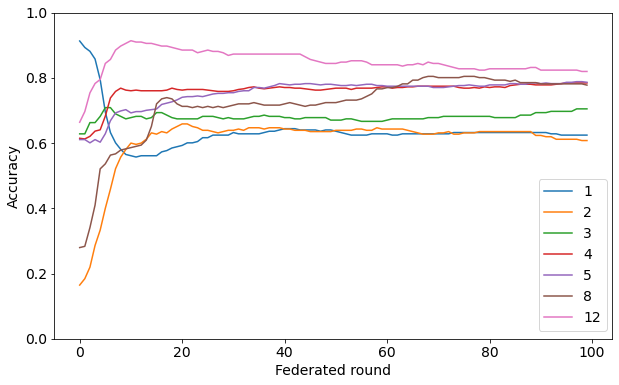

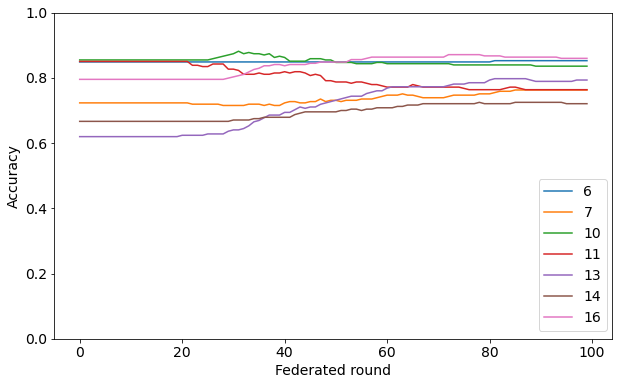

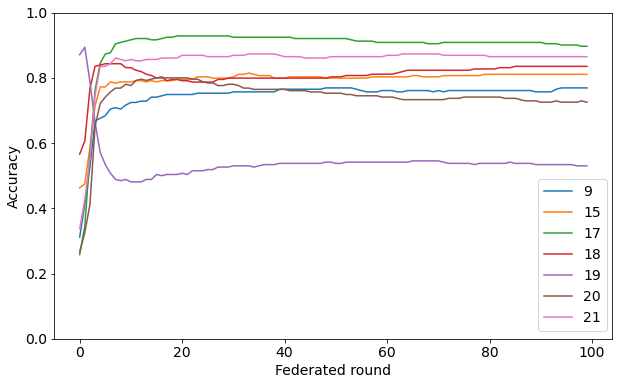

In [71]:
import matplotlib

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

for empresa in IDS_EMPRESA:
    df = pd.read_csv(f'./results/hito1_v3-empresa_{empresa}.csv')
    
    print(f'Acc máximo empresa {empresa}: {df.mean(numeric_only=True, axis=1).max():.2f} - {df.mean(numeric_only=True, axis=1).idxmax()+1}')
    
    f = plt.figure(figsize=(10,6))
    ax = f.add_subplot()
    df.plot(ax=ax,ylim=(0,1))
    
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Federated round")
    
    plt.legend(bbox_to_anchor=(0.99, 0.025), loc='lower right', borderaxespad=0, ncol=1)
    
    plt.savefig(f'../recursos/H1-empresa_{empresa}-entrenamiento-federado.pdf', bbox_inches='tight')

# Comprobar rendimiento de la mejor ronda para cada empresa con conductores desconocidos

In [16]:
def prepare_model_data(client_file):
    df = pd.read_csv(client_file)
    
    train, test = train_test_split(df, test_size=0.30, random_state=42)
    
    X_train = train[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    X_test = test[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    y_train = train['y_class']
    y_test = test['y_class']
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

def cargar_dataset_varios_clientes(clientes):
    base_path = "./data/centralizado"
    
    X_train, X_val, y_train, y_val = prepare_model_data(f'{base_path}/cliente_{clientes[0]}.csv')
    
    for cid in clientes[1:]:
        path = f'{base_path}/cliente_{cid}.csv'
        X_train_act, X_val_act, y_train_act, y_val_act = prepare_model_data(path)
    
        X_train = np.vstack((X_train, X_train_act))
        X_val = np.vstack((X_val, X_val_act))
        y_train = np.concatenate((y_train, y_train_act))
        y_val = np.concatenate((y_val, y_val_act))
        
    return X_train, X_val, y_train, y_val

def setup_model(weights_path):
    neurons = 36
    activation = "relu"
    learning_rate = 0.180165
    optimizer = Adadelta(learning_rate=learning_rate)

    input_shape = (7,)

    # Create model
    model = Sequential()

    model.add(Dense(neurons, input_shape=input_shape, activation=activation))

    model.add(BatchNormalization())

    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
    
    a = np.load(weights_path, allow_pickle=True)

    n_elems = [252, 36,
               36, 36, 36, 36,
               1296, 36,
               1296, 36,
               1296, 36,
               36, 1]

    weights = []

    # https://numpy.org/devdocs/reference/generated/numpy.lib.format.html#version-numbering
    # En base a la doc sabemos que los datos de interes estan al final, y como deben ser float32 => 4 bytes
    # por lo que se toman los n_elementos*4bytes del final

    for i, t in enumerate(a["arr_0"][0].tensors):
        act = np.frombuffer(t[-n_elems[i]*4:], dtype=np.float32)
        weights.append(act)

    # Se cambia la forma para que se adapte a la del modelo
    weights[0] = weights[0].reshape(7,36)
    weights[6] = weights[6].reshape(36,36)
    weights[8] = weights[8].reshape(36,36)
    weights[10] = weights[10].reshape(36,36)
    weights[12] = weights[12].reshape(36,1)

    model.set_weights(weights)
    
    return model

def evaluate_FLmodel(KCs, UCs, empresa, rnd):
    path = f"./rounds/hito1_v3-empresa_{empresa}-round-{rnd}-weights.npz"
    model = setup_model(path)
    
    # Evaluar para los clientes conocidos
    X_train, X_val, y_train, y_val = cargar_dataset_varios_clientes(KCs)
    res = model.evaluate(X_val, y_val, verbose=0)
    
    tp_k = res[2]
    tn_k = res[3]
    fp_k = res[4]
    fn_k = res[5]
    
    k_acc = (tp_k+tn_k)/(tp_k+tn_k+fp_k+fn_k)
    k_sens = (tp_k)/(tp_k+fn_k)
    k_spec = (tn_k)/(tn_k+fp_k)
    k_f1 = (tp_k)/( tp_k + (fp_k+fn_k)/2 )
    
    # Evaluar para los clientes nuevos
    X_train, X_val, y_train, y_val = cargar_dataset_varios_clientes(UCs)
    res_c = model.evaluate(X_val, y_val, verbose=0)
    
    tp_u = res_c[2]
    tn_u = res_c[3]
    fp_u = res_c[4]
    fn_u = res_c[5]
    
    u_acc = (tp_u+tn_u)/(tp_u+tn_u+fp_u+fn_u)
    u_sens = (tp_u)/(tp_u+fn_u)
    u_spec = (tn_u)/(tn_u+fp_u)
    u_f1 = (tp_u)/( tp_u + (fp_u+fn_u)/2 )
    
    return k_acc, k_sens, k_spec, k_f1, u_acc, u_sens, u_spec, u_f1

In [21]:
CONDUCTORES_IDS = {
    1: [3,4,5,12,  2,8,  1],
    2: [13,14,    6,7,10,11,16],
    3: [15,18,  9,17,20,21,  19]
}

ALL_IDS = list(range(1,21+1))

results_fed_empresa = pd.DataFrame(columns=["Empresa", "k_acc", "k_sens", "k_spec", "k_f1", "u_acc", "u_sens", "u_spec", "u_f1"])

for emp_id in CONDUCTORES_IDS:
    df = pd.read_csv(f'./results/hito1_v3-empresa_{emp_id}.csv')
    df["mean"] = df.mean(numeric_only=True, axis=1)

    best_rnd = df["mean"].idxmax()+1
    
    KCs = CONDUCTORES_IDS[emp_id]
    UCs = list(set(ALL_IDS)-set(KCs))
    
    k_acc, k_sens, k_spec, k_f1, u_acc, u_sens, u_spec, u_f1 = evaluate_FLmodel(KCs, UCs, emp_id, best_rnd)
            
    # Almacenar resultados
    fed_empresa = {
        "Empresa": emp_id,
        "k_acc": k_acc,
        "k_sens": k_sens,
        "k_spec": k_spec,
        "k_f1": k_f1,
        "u_acc": u_acc,
        "u_sens": u_sens,
        "u_spec": u_spec,
        "u_f1": u_f1
    }
    results_fed_empresa = results_fed_empresa.append(fed_empresa, ignore_index=True)
    
results_fed_empresa.round(2)

,Empresa,k_acc,k_sens,k_spec,k_f1,u_acc,u_sens,u_spec,u_f1
0,1.0,0.74,0.74,0.75,0.76,0.67,0.65,0.70,0.70
1,2.0,0.80,0.93,0.39,0.88,0.55,0.92,0.17,0.68
2,3.0,0.78,0.59,0.92,0.70,0.63,0.49,0.88,0.63
